<a href="https://colab.research.google.com/github/jrod-projects-hub/Portfolio-Projects/blob/main/BCGEnergy%26GasCaseAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data initial understanding
- .head()
- .info() # num of records
- .describe()
- unique values

In [ ]:
# created by jaime rodriguez
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# CUSTOM VISUALIZATION FUNCTION DEF
# -plot_stacked_bars
# -annotate_stacked_bars
# -plot_distributions


def plot_stacked_bars2(df, groupby_col, value_col, stacked_type='single', operation_done=['percent'], title_='title', size_=(18, 10), rot_=0, legend_='upper right'):
  '''plot stacked bar chart with annotations
  Args:
      df: DataFrame containing the data to be plotted.
      groupby_col: Column to group by (default: None).
      value_col: column containing values to aggregate
      stacked_type: Type of stacked bar chart ('single' or 'separate').
      operation_done: converts raw data values that were grouped into the percentage version
      title_: Title of the plot.
      size_: Tuple specifying the figure size (default: (18, 10)).
      rot_: Rotation angle for x-axis labels (default: 0).
      legend_: Location of the legend (default: 'upper right').
  '''
  if stacked_type == 'single':  # Create a single stacked bar
    if 'percent' in operation_done:
      # Group by 'groupby_col' and 'value_col' and get counts
      grouped = df.groupby([groupby_col, value_col])[value_col].count().reset_index(name='count')
      print(df.groupby(groupby_col)[groupby_col].count().reset_index(name='count'))
      # Create a list to store the data for the stacked bar
      data = []
      labels = []

      # Iterate through unique values in 'groupby_col' (e.g., 0 and 1 for 'churn')
      for group_val in df[groupby_col].unique():
        # Filter data for the current group
        group_data = grouped[grouped[groupby_col] == group_val] #'if data in the grouped col = group val in this particular iteration of loop(one iteration per unique value in groupby col) then store teh data in group data

        # Append counts to the data list and labels to the labels list
        data.append(group_data['count'].values) #stores the values from group_data's 'count' col's current iteration (one for each unique value of group by col) into the data list
        labels.append(group_data[value_col].values) #extracts category label,(which is teh nth iteration value of geoing through the unique values in the group by col)
      total_churn_count=data[0].sum()/ (data[0].sum()+data[1].sum())*100
      total_retention_count=data[1].sum()/ (data[0].sum()+data[1].sum())*100
      data=[[total_retention_count], [total_churn_count]]
      # Create the stacked bar plot
      fig, ax = plt.subplots(figsize=size_)

      ax.bar(x=['Overall'], height=data[0], color='blue')  # First group


      # Add the second group as a stacked bar (if it exists)
      if len(data) > 1:
          bottom = data[0]  # Use the first group as the bottom for the second
          ax.bar(x=['Overall'], height=data[1], bottom=bottom, color=['red'])  # Second group

      #annotate the bars
      for p in ax.patches:
        value = str(round(p.get_height(), 1))
        if value == '0.0':
            continue
        ax.annotate(value, (p.get_x() + p.get_width() / 2, (p.get_y() + p.get_height() / 2) * 0.99),
                    color='white', size=14, ha='center', va='center')  # Adjust alignment for better readability
      # Create legend handles (the colored rectangles) and labels
      legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color='blue', label='Retention'),  # Blue for Retention
        plt.Rectangle((0, 0), 1, 1, color='red', label='Churn')     # Red for Churn
        ]

    # Add the legend using the handles and labels
    ax.legend(handles=legend_handles, loc='lower right') # You can adjust the 'loc' parameter for legend position
    plt.title(title_)
      # ... (Rest of the function for annotations, labels, etc. - adapt as needed) ...

  elif stacked_type == 'separate':  # Create separate stacked bars
    if 'percent' in operation_done:
      # Group by 'groupby_col', 'value_col', and 'churn' to get percentages
      grouped = df.groupby([groupby_col, value_col])[value_col].count().reset_index(name='count')
      print(grouped)
      # Calculate churn percentages within each 'has_gas' group
      grouped['percentage'] = grouped.groupby([value_col])['count'].transform(lambda x: (x / x.sum()) * 100)

      # Pivot the data for plotting
      pivot_df = grouped.pivot(index=value_col, columns=['churn'], values='percentage').fillna(0)

      # Create the stacked bar chart
      ax = pivot_df.plot(kind='bar', stacked=True, figsize=size_, rot=rot_, title=title_, color=['blue', 'red'])

      # ... (Rest of the function for annotations, labels, etc. - adapt as needed) ...
      # Annotate bars
      for p in ax.patches:
        value = str(round(p.get_height(), 1))
        if value == '0.0':
            continue
        ax.annotate(value, (p.get_x() + p.get_width() / 2, (p.get_y() + p.get_height() / 2) * 0.99),
                    color='white', size=14, ha='center', va='center')  # Adjust alignment for better readability

    #Set title and show plot
    # plt.title(title_)
    # plt.legend()  # Add a legend
    # plt.show()



def annotate_stacked_bars(ax,pad=0.99, colour='white', textsize=13):
  '''annotate stacked bars'''
  for p in ax.patches:
    #calculate annotation
    value=str(round(p.get_height(), 1))
    # if value is 0 do not annotate
    if value == '0.0':
      continue
    #annotate
    ax.annotate(value, (p.get_x() + p.get_width()/2, (p.get_y()+p.get_height()/2)*pad),
                color=colour, size=textsize)

def plot_distribution(df, column, ax, bins_=50):
  '''
  plot variabel distribution in a stacked histogram of churned or retained company
  '''
  #create a temporal df w/ the data to be plot
  temp = pd.DataFrame({'retention': df[df['churn']==0][column],
                       "churn": df[df['churn']==1][column]})
  #plot the histogram
  temp[['retention', 'churn']].plot(kind='hist', bins=bins_, ax=ax,stacked=True)
  #x-axis lable
  ax.set_xlabel(column)
  #chang the x axis to plain style
  ax.ticklabel_format(style='plain', axis='x')



#OUTLIER DETECTION FUNCTION(S)
def outlier_count(df, feature):
    #outlier_count= []
    Q1= df[feature].quantile(0.25)
    Q3= df[feature].quantile(0.75)
    IQR= Q3-Q1
    lower_bound= Q1-1.5*IQR
    upper_bound= Q3+1.5*IQR
    outliers= df[((df[feature].values)<lower_bound) | ((df[feature].values)>upper_bound)]
    #outlier_count.append((feature, len(outliers)))
    return len(outliers)



In [ ]:
#upload files
!rm -f client_data.csv
!rm -f price_data.csv
uploaded= files.upload()

Saving clean_data_after_eda.csv to clean_data_after_eda.csv
Saving client_data.csv to client_data.csv
Saving price_data.csv to price_data.csv


In [ ]:
#convert files into df
client_df= pd.read_csv(io.BytesIO(uploaded['client_data.csv']))
price_df= pd.read_csv(io.BytesIO(uploaded['price_data.csv']))
cleaned_df= pd.read_csv(io.BytesIO(uploaded['clean_data_after_eda.csv']))

# Client data

In [ ]:
client_df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0         0         54946                0  2013-06-15  2016-06-15   
1      4660             0                0  2009-08-21  2016-08-30   
2       544             0                0  2010-04-16  2016-04-16   
3      1584             0                0  2010-03-30  2016-03-30   
4      4425             0              526  2010-01-13  2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  forecast_cons_year  \
0      2015-11-01   2015-06-23               0.00                   0   
1      2009-08-21   2015-08-31             189.95                   0   
2      2010-04-16   2015-04-17              47.96                   0   
3      2010-03-30   2015-03-31             240.04                   0   
4      2010-01-13   2015-03-09             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114481                    0.098142   
1                        0.145711                    0.000000   
2                        0.165794                    0.087899   
3                        0.146694                    0.000000   
4                        0.116900                    0.100015   

   forecast_price_pow_off_peak has_gas  imp_cons  margin_gross_pow_ele  \
0                    40.606701       t      0.00                 25.44   
1                    44.311378       f      0.00                 16.38   
2                    44.311378       f      0.00                 28.60   
3                    44.311378       f      0.00                 30.22   
4                    40.606701       f     52.32                 44.91   

   margin_net_pow_ele  nb_prod_act  net_margin  num_years_antig  \
0               25.44            2      678.99                3   
1               16.38            1       18.89                6   
2               28.60            1        6.60                6   
3               30.22            1       25.46                6   
4               44.91            1       47.98                6   

                          origin_up  pow_max  churn  
0  lxidpiddsbxsbosboudacockeimpuepw   43.648      1  
1  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.800      0  
2  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.856      0  
3  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.200      0  
4  kamkkxfxxuwbdslkwifmmcsiusiuosws   19.800      0

In [ ]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [ ]:
duplicates= client_df.duplicated()
print(f'number of duplicates: {duplicates.sum()}')

number of duplicates: 0


<mark>
INSIGHT 1: (Quality of Dataset)
<div>
<mark>
Client data set has: <div><mark>
- no nulls<div><mark>
- no duplicates


In [ ]:
#determine the unique values per feature
for feature in client_df.columns:
  print(f'{feature}: {client_df[feature].unique()}', '\n')


id: ['24011ae4ebbe3035111d65fa7c15bc57' 'd29c2c54acc38ff3c0614d0a653813dd'
 '764c75f661154dac3a6c254cd082ea7d' ... '10e6828ddd62cbcf687cb74928c4c2d2'
 '1cf20fd6206d7678d5bcafd28c53b4db' '563dde550fd624d7352f3de77c0cdfcd'] 

channel_sales: ['foosdfpfkusacimwkcsosbicdxkicaua' 'MISSING'
 'lmkebamcaaclubfxadlmueccxoimlema' 'usilxuppasemubllopkaafesmlibmsdf'
 'ewpakwlliwisiwduibdlfmalxowmwpci' 'epumfxlbckeskwekxbiuasklxalciiuu'
 'sddiedcslfslkckwlfkdpoeeailfpeds' 'fixdbufsefwooaasfcxdxadsiekoceaa'] 

cons_12m: [    0  4660   544 ... 87146 32270  7223] 

cons_gas_12m: [  54946       0 1542867 ...    2126    3036   47940] 

cons_last_month: [     0    526   1998 ... 154171   3269  11367] 

date_activ: ['2013-06-15' '2009-08-21' '2010-04-16' ... '2009-04-30' '2013-03-10'
 '2004-12-29'] 

date_end: ['2016-06-15' '2016-08-30' '2016-04-16' '2016-03-30' '2016-03-07'
 '2016-12-09' '2016-12-02' '2016-04-21' '2016-09-23' '2016-05-04'
 '2016-07-11' '2016-11-26' '2016-10-30' '2017-01-22' '2016-12-01'
 

In [ ]:
client_df_copy=client_df.copy()


#order features in df by: {0:3}id features||||| {3-7}date features (YYY-MM-DD),|||||||     {7:24}numerical features (7:13 is historical and forecasted consumption),||||||     (24:25}categorical features,|||||||   {25:26}target variable
client_df_corrected_original_index_order = [0,1,23,5,6,7,8,    2,3,4,9,10,11,12,13,14,15,17,18,19,20,21,22,24,     16,25]
client_df_new_index_order = [client_df_copy.columns[i] for i in client_df_corrected_original_index_order]
client_df_copy = client_df_copy.reindex(columns=client_df_new_index_order)

for i, feature in enumerate(client_df.columns):
  print(f'{i}: {feature}')

0: id
1: channel_sales
2: cons_12m
3: cons_gas_12m
4: cons_last_month
5: date_activ
6: date_end
7: date_modif_prod
8: date_renewal
9: forecast_cons_12m
10: forecast_cons_year
11: forecast_discount_energy
12: forecast_meter_rent_12m
13: forecast_price_energy_off_peak
14: forecast_price_energy_peak
15: forecast_price_pow_off_peak
16: has_gas
17: imp_cons
18: margin_gross_pow_ele
19: margin_net_pow_ele
20: nb_prod_act
21: net_margin
22: num_years_antig
23: origin_up
24: pow_max
25: churn


In [ ]:
#describe the numerical features in client data
client_df_copy.iloc[:,7:24].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.795000   
75%           1745.750000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak      imp_cons  margin_gross_pow_ele  \
count                 14606.000000  14606.000000          14606.000000   
mean                     43.130056    152.786896             24.565121   
std                       4.485988    341.369366             20.231172   
min                       0.000000      0.000000              0.000000   
25%                      40.606701      0.000000             14.280000   
50%                      44.311378     37.395000             21.640000   
75%                      44.311378    193.980000             29.880000   
max                      59.266378  15042.790000            374.640000   

       margin_net_pow_ele   nb_prod_act    net_margin  num_years_antig  \
count        14606.000000  14606.000000  14606.000000     14606.000000   
mean            24.562517      1.292346    189.264522         4.997809   
std             20.230280      0.709774    311.798130         1.611749   
min              0.000000      1.000000      0.000000         1.000000   
25%             14.280000      1.000000     50.712500         4.000000   
50%             21.640000      1.000000    112.530000         5.000000   
75%             29.880000      1.000000    243.097500         6.000000   
max            374.640000     32.000000  24570.650000        13.000000   

            pow_max  
count  14606.000000  
mean      18.135136  
std       13.534743  
min        3.300000  
25%       12.500000  
50%       13.856000  
75%       19.172500  
max      320.000000

## Data Visualizaton
- overall churn rate of clients
- consumption of pwr/elec-features by clients and thier resulting churn rates  
- client feature distributions (for numerical vars)

   churn  count
0      0  13187
1      1   1419


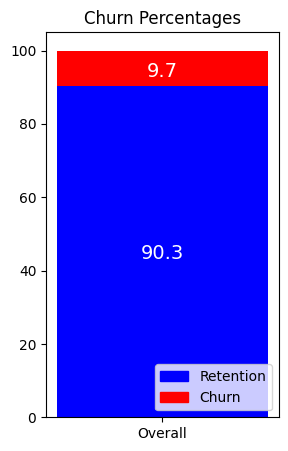

In [ ]:
plot_stacked_bars2(client_df_copy, groupby_col='churn', value_col='id', stacked_type='single', title_='Churn Percentages', size_=(3,5), legend_='lower right')

<mark>INSIGHT 2:<div>
<mark>
90.3% of PowerCo's clients are retained, while 9.7% have churned. 9.7% is considered a high amount of churn.

   churn has_gas  count
0      0       f  10753
1      0       t   2434
2      1       f   1202
3      1       t    217


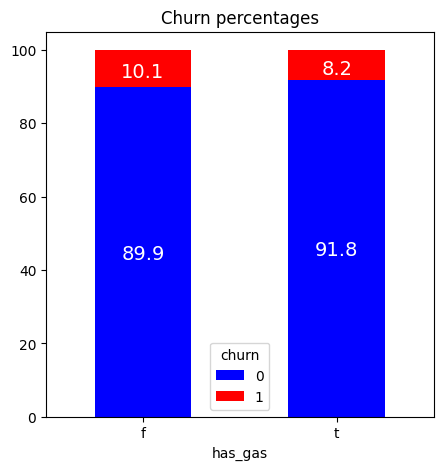

In [ ]:
plot_stacked_bars2(client_df_copy, groupby_col='churn', value_col='has_gas', stacked_type='separate', title_='Churn percentages', size_=(5,5), legend_='lower right')

<mark>INSIGHT 3:<div>
<mark>
churn rates differ between PowerCo's clients who use and those who do not use gas by 2.1%, which likely indicates no meaningful distinction between client's use of gas relative to churn rates.

    churn                     channel_sales  count
0       0                           MISSING   3442
1       0  epumfxlbckeskwekxbiuasklxalciiuu      3
2       0  ewpakwlliwisiwduibdlfmalxowmwpci    818
3       0  fixdbufsefwooaasfcxdxadsiekoceaa      2
4       0  foosdfpfkusacimwkcsosbicdxkicaua   5934
5       0  lmkebamcaaclubfxadlmueccxoimlema   1740
6       0  sddiedcslfslkckwlfkdpoeeailfpeds     11
7       0  usilxuppasemubllopkaafesmlibmsdf   1237
8       1                           MISSING    283
9       1  ewpakwlliwisiwduibdlfmalxowmwpci     75
10      1  foosdfpfkusacimwkcsosbicdxkicaua    820
11      1  lmkebamcaaclubfxadlmueccxoimlema    103
12      1  usilxuppasemubllopkaafesmlibmsdf    138


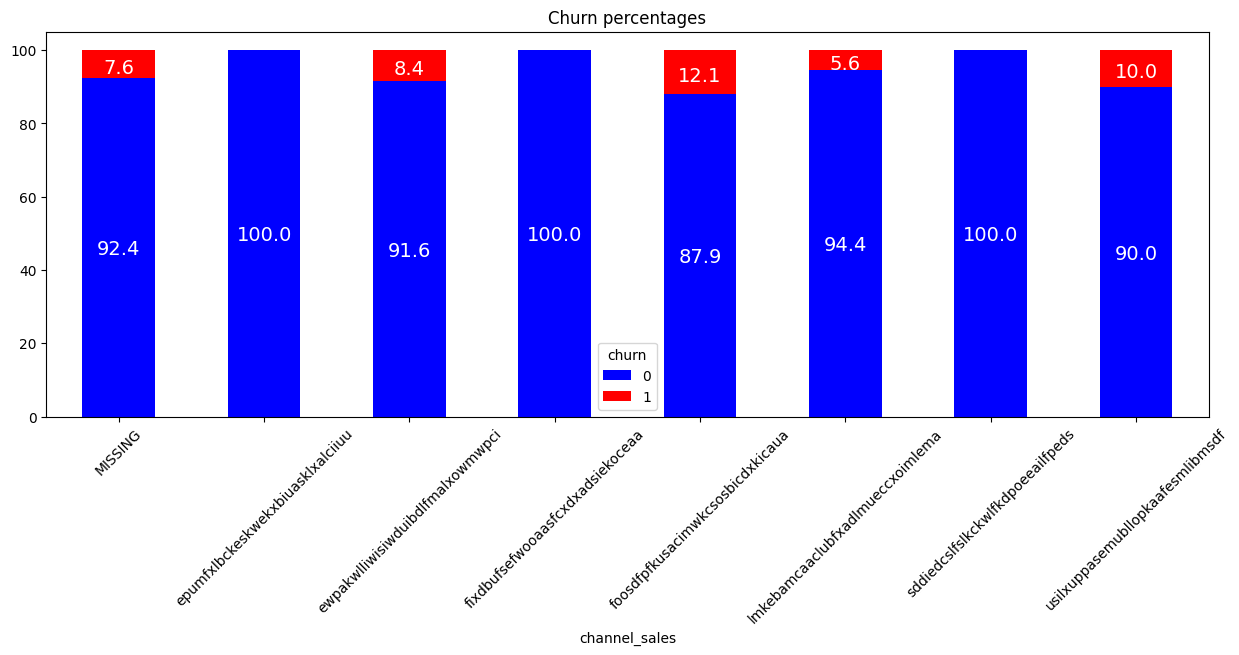

In [ ]:
plot_stacked_bars2(client_df_copy, groupby_col='churn', value_col='channel_sales', stacked_type='separate', title_='Churn percentages', size_=(15,5), legend_='lower right', rot_=45)

    churn  nb_prod_act  count
0       0            1  10290
1       0            2   2237
2       0            3    471
3       0            4    135
4       0            5     28
5       0            6      8
6       0            8      4
7       0            9     11
8       0           10      2
9       0           32      1
10      1            1   1141
11      1            2    208
12      1            3     52
13      1            4     15
14      1            5      3


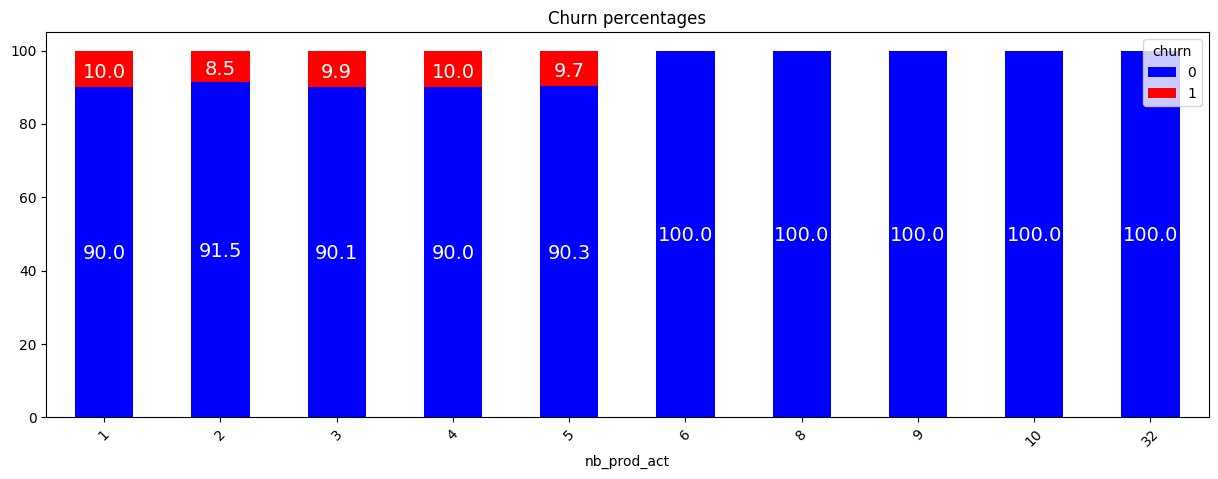

In [ ]:
plot_stacked_bars2(client_df_copy, groupby_col='churn', value_col='nb_prod_act', stacked_type='separate', title_='Churn percentages', size_=(15,5), legend_='lower right', rot_=45)

    churn  num_years_antig  count
0       0                1      1
1       0                2      8
2       0                3   2104
3       0                4   3510
4       0                5   2117
5       0                6   4430
6       0                7    467
7       0                8     98
8       0                9     91
9       0               10     77
10      0               11    173
11      0               12     99
12      0               13     12
13      1                2      3
14      1                3    329
15      1                4    472
16      1                5    200
17      1                6    339
18      1                7     42
19      1                8      5
20      1                9      1
21      1               10      4
22      1               11     12
23      1               12     11
24      1               13      1


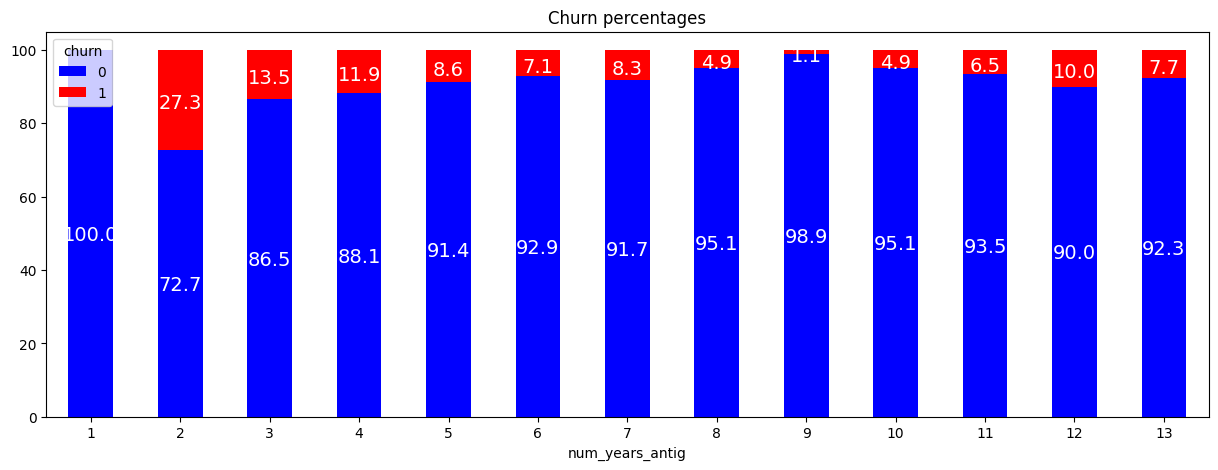

In [ ]:
plot_stacked_bars2(client_df_copy, groupby_col='churn', value_col='num_years_antig', stacked_type='separate', title_='Churn percentages', size_=(15,5), legend_='lower right')

   churn                         origin_up  count
0      0                           MISSING     60
1      0  ewxeelcelemmiwuafmddpobolfuxioce      1
2      0  kamkkxfxxuwbdslkwifmmcsiusiuosws   4036
3      0  ldkssxwpmemidmecebumciepifcamkci   2884
4      0  lxidpiddsbxsbosboudacockeimpuepw   6204
5      0  usapbepcfoloekilkwsdiboslwaxobdp      2
6      1                           MISSING      4
7      1  kamkkxfxxuwbdslkwifmmcsiusiuosws    258
8      1  ldkssxwpmemidmecebumciepifcamkci    264
9      1  lxidpiddsbxsbosboudacockeimpuepw    893


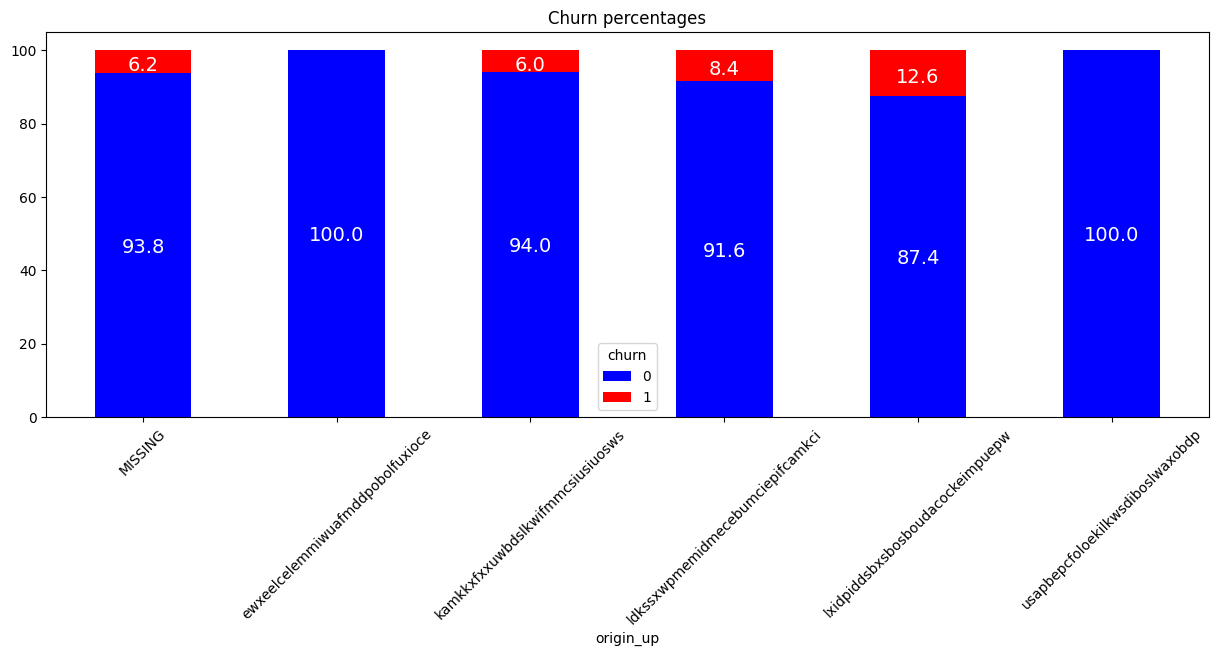

In [ ]:
plot_stacked_bars2(client_df_copy, groupby_col='churn', value_col='origin_up', stacked_type='separate', title_='Churn percentages', size_=(15,5), legend_='lower right', rot_=45)

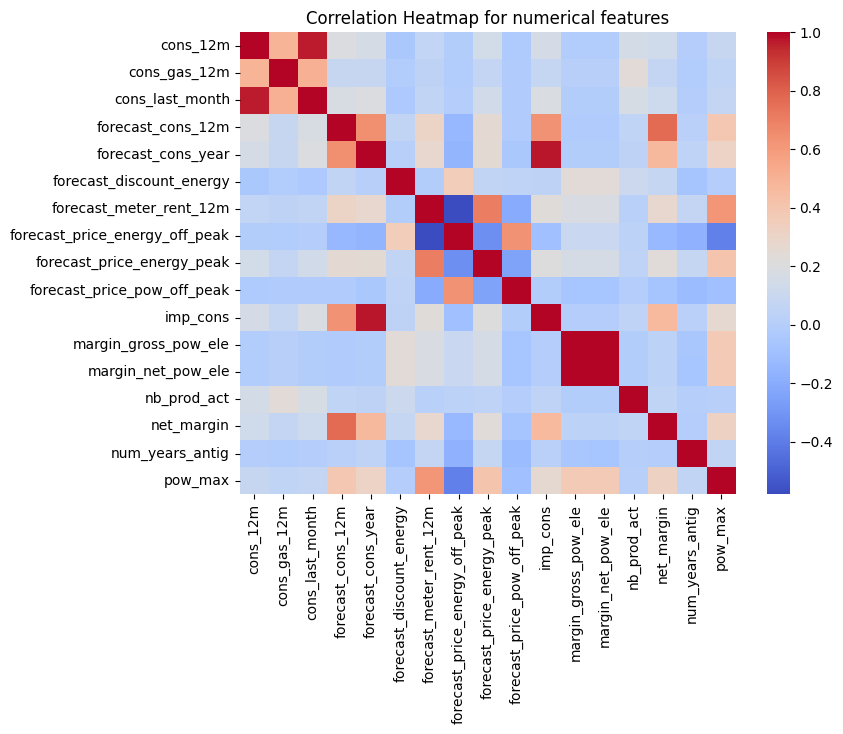

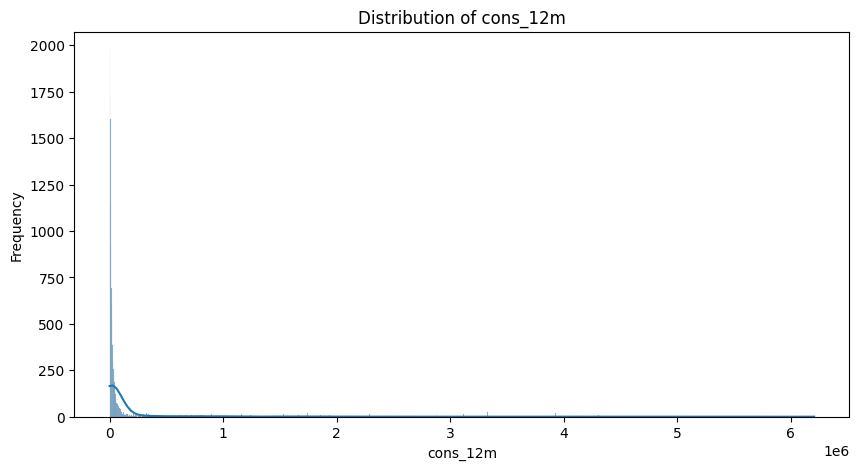

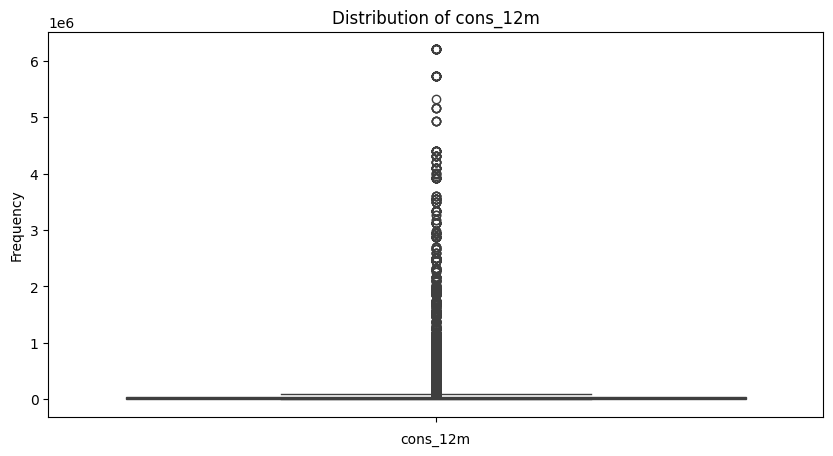

 outlier orignal count: 2084


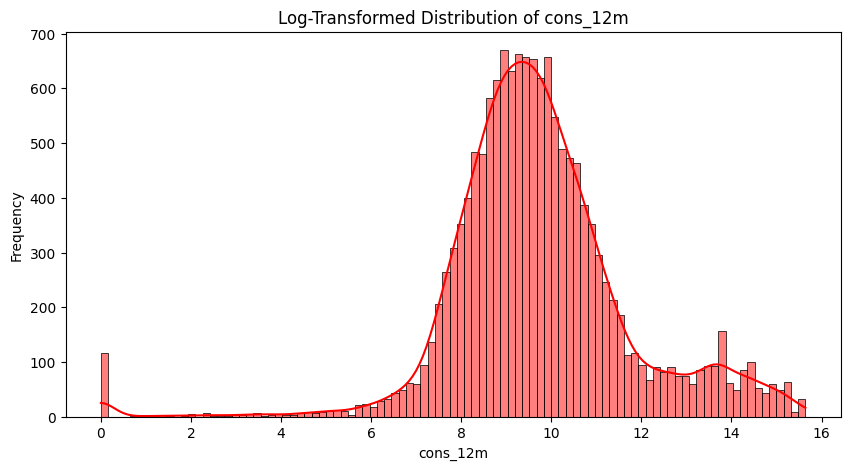

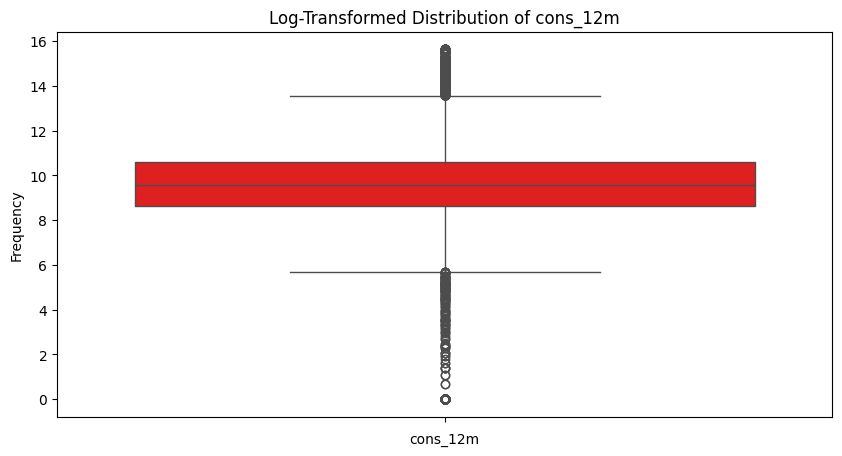

log transformed outlier count: 1102


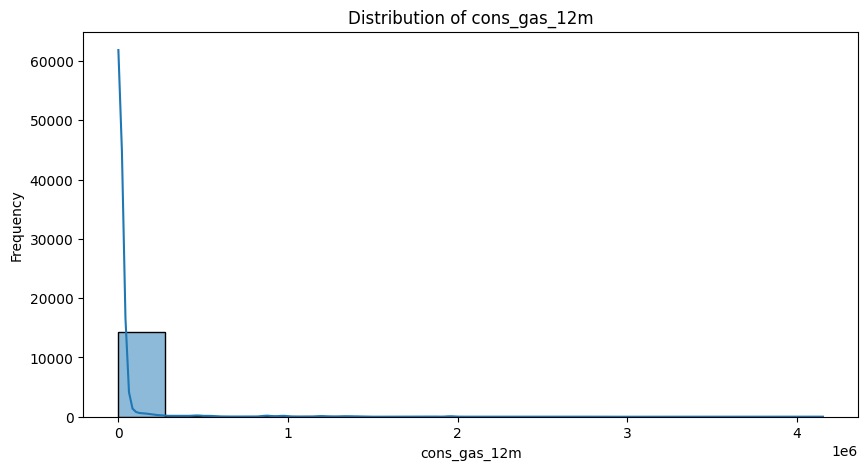

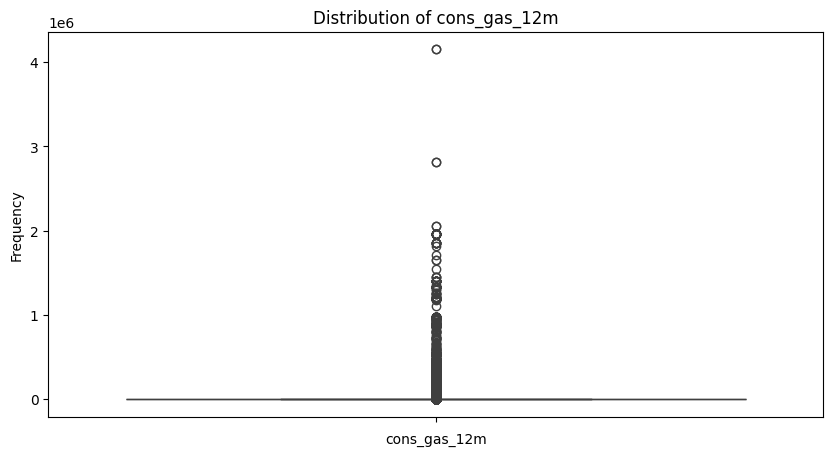

 outlier orignal count: 2612


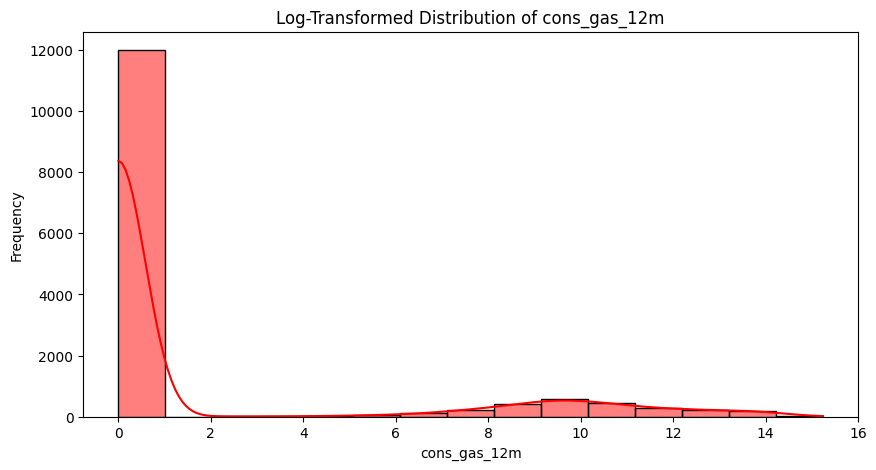

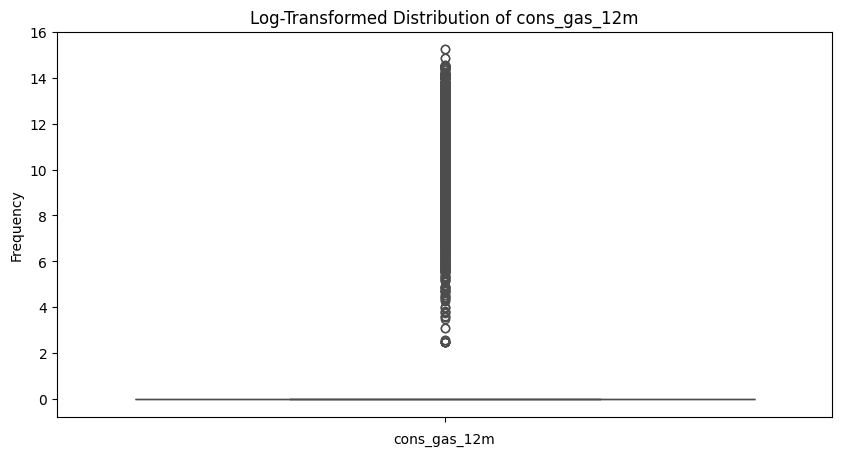

log transformed outlier count: 2612


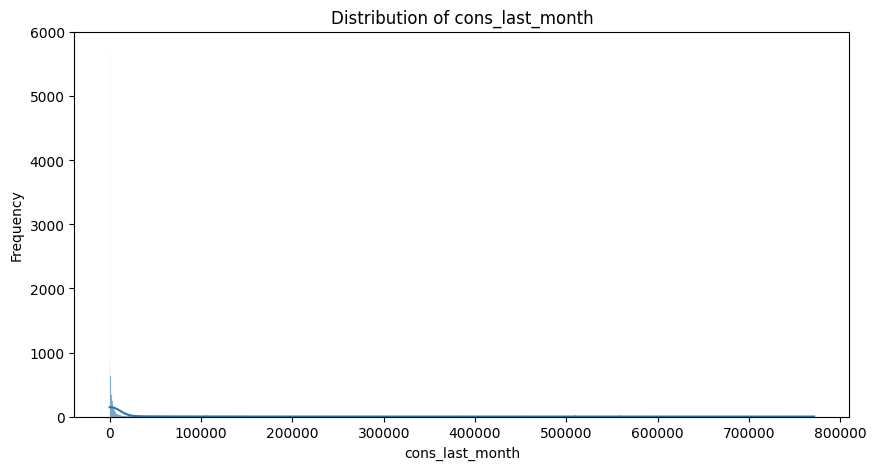

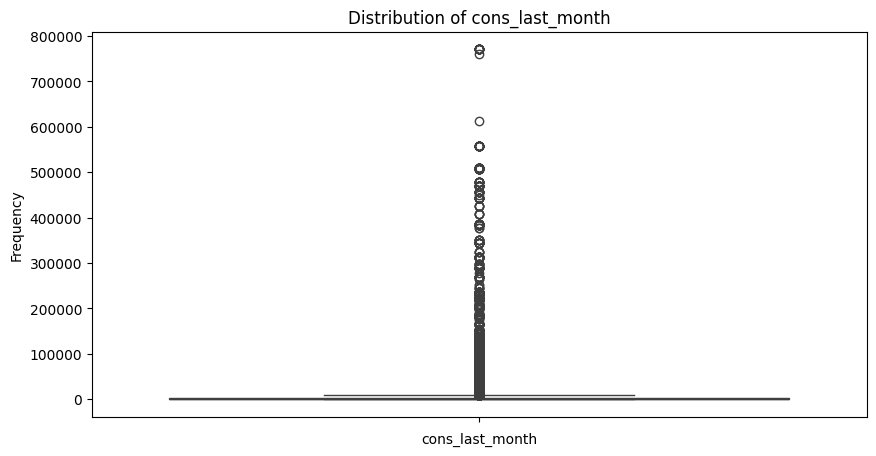

 outlier orignal count: 2051


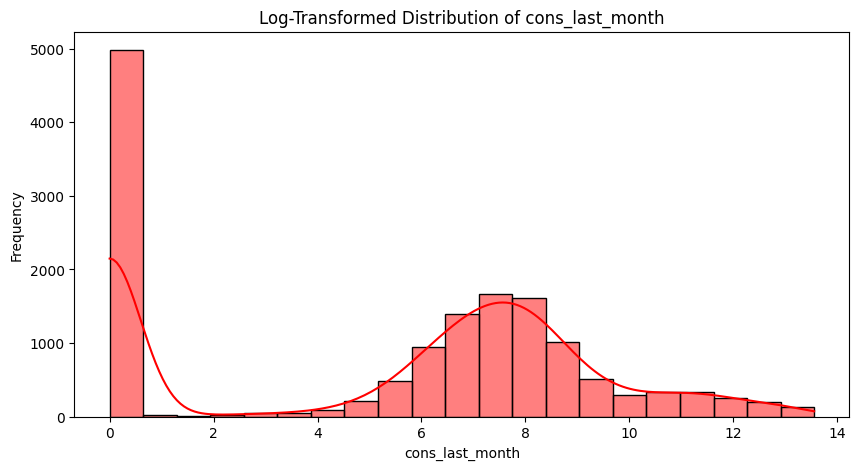

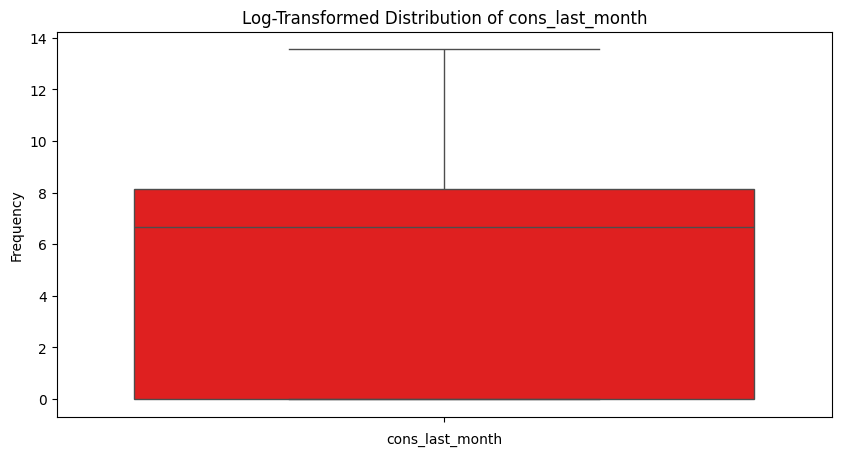

log transformed outlier count: 0


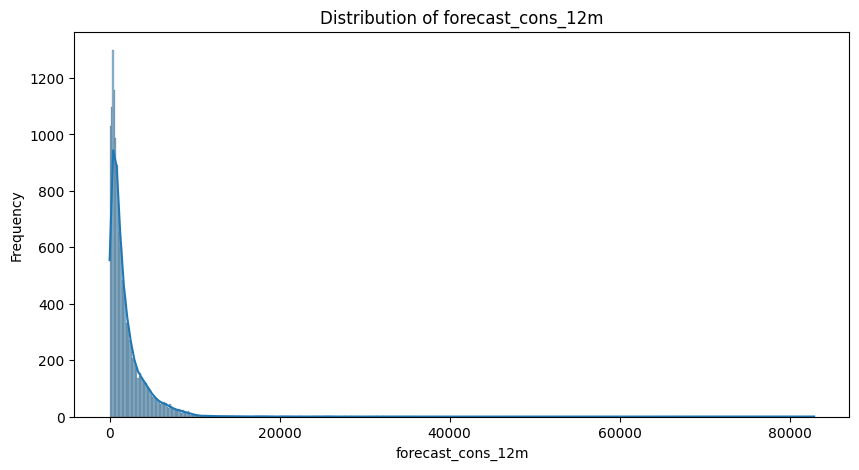

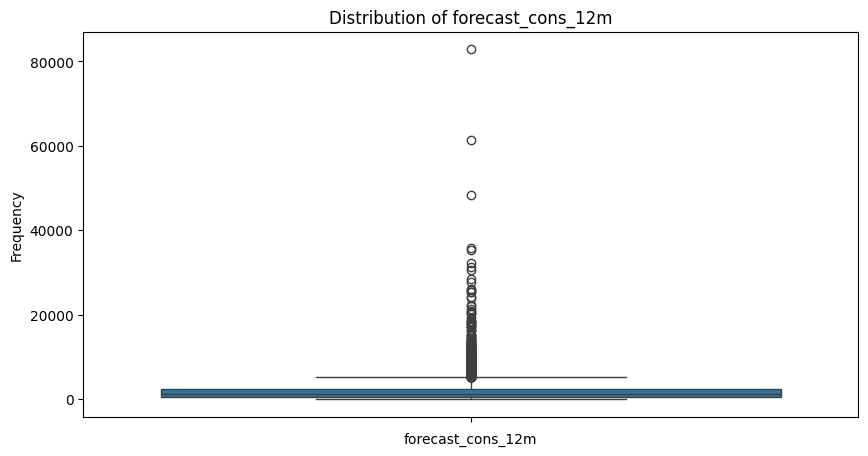

 outlier orignal count: 1054


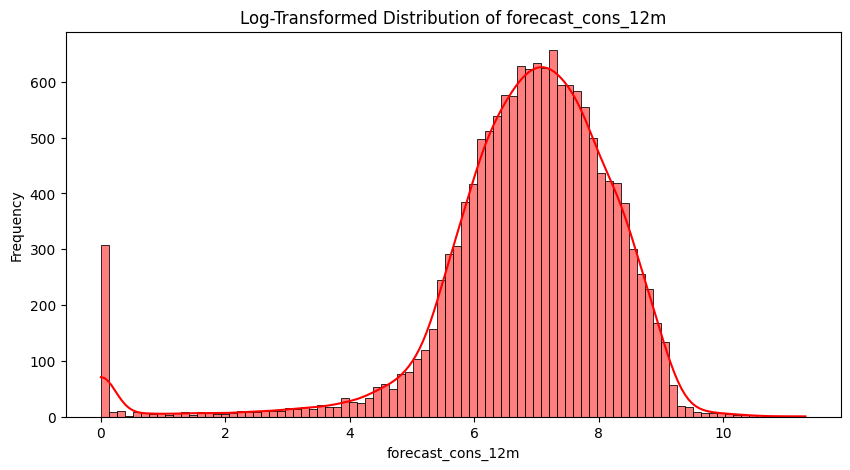

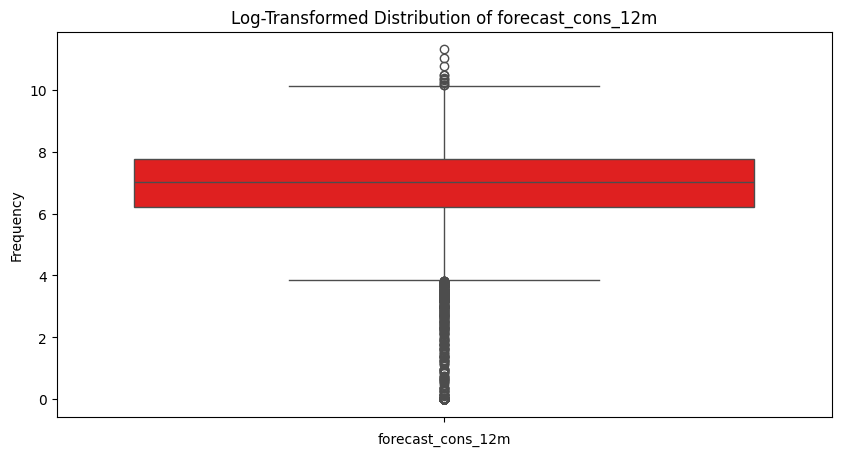

log transformed outlier count: 582


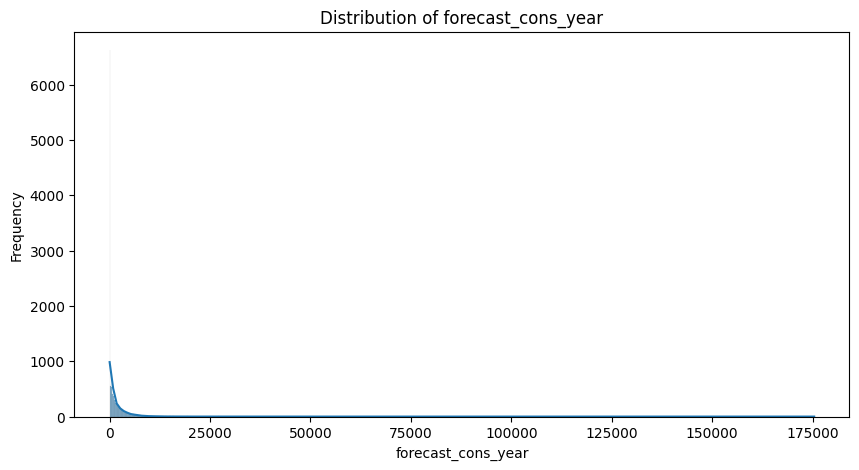

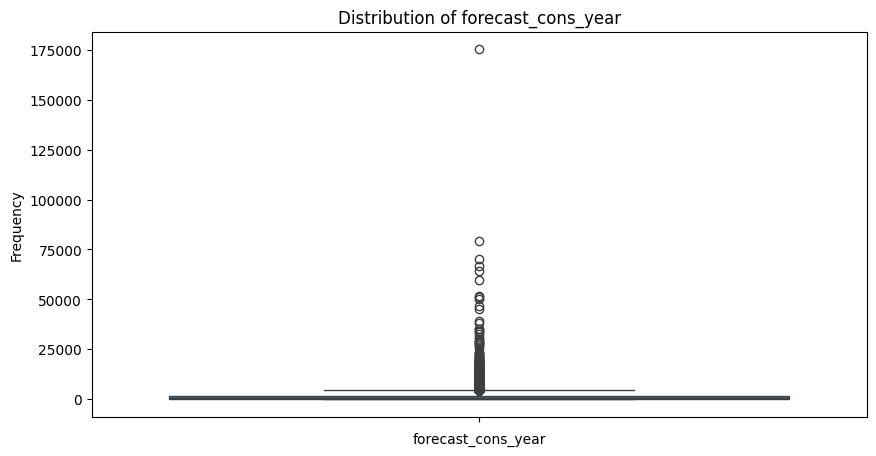

 outlier orignal count: 1298


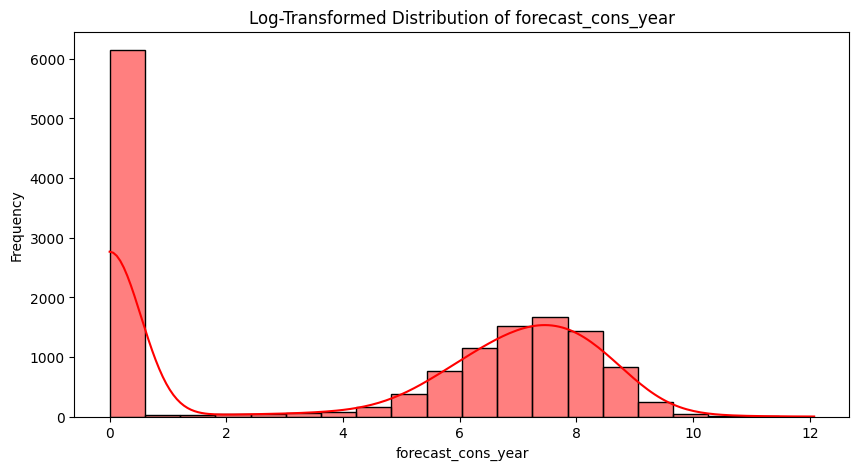

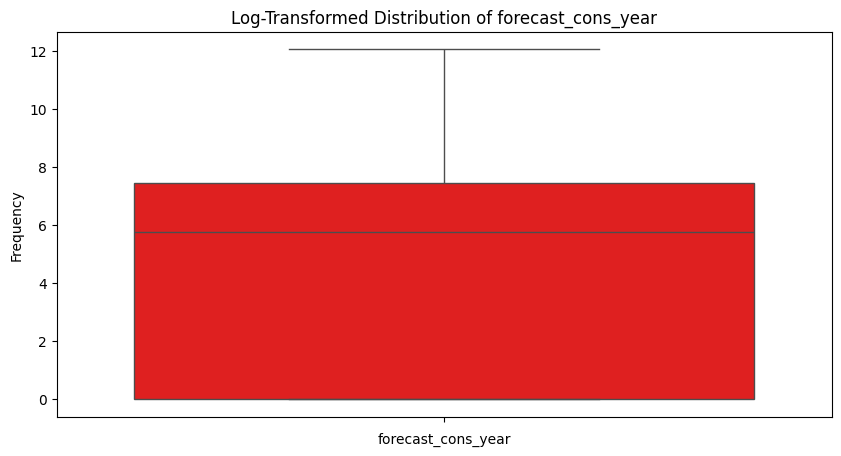

log transformed outlier count: 0


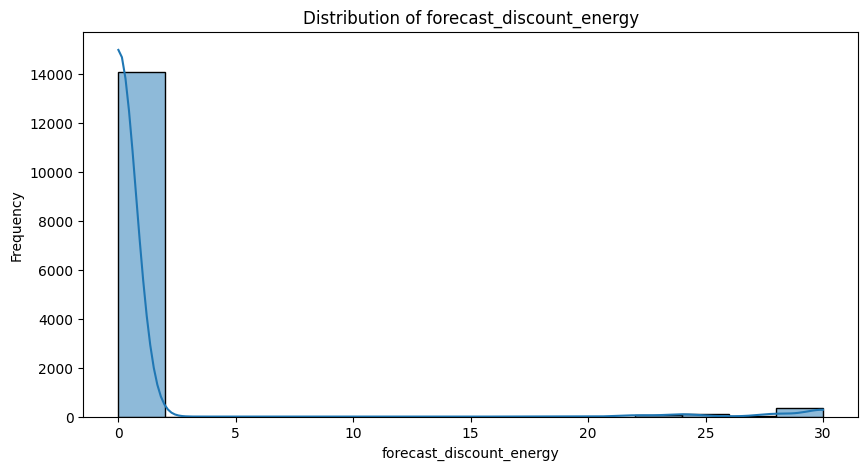

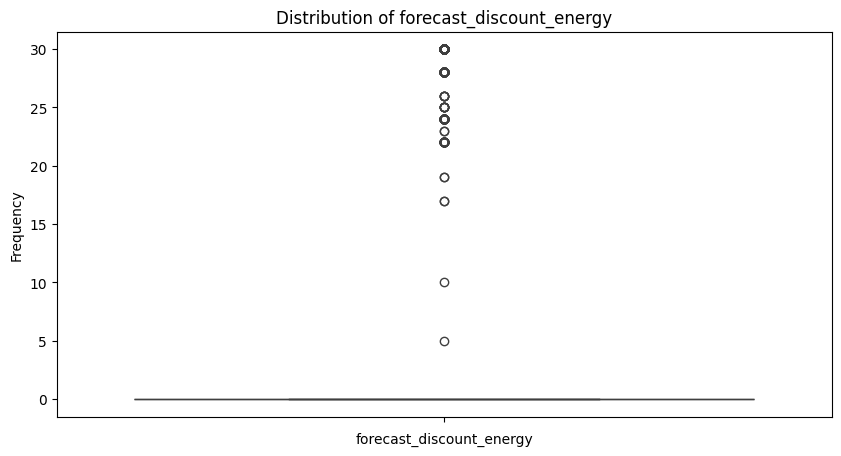

 outlier orignal count: 512


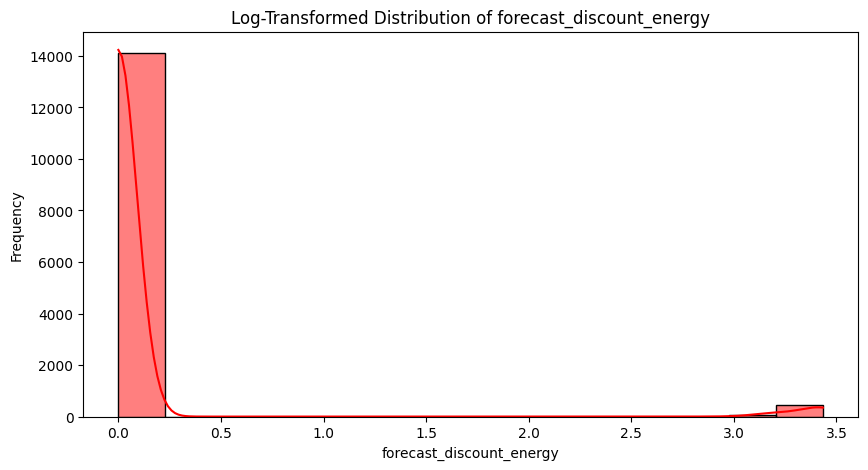

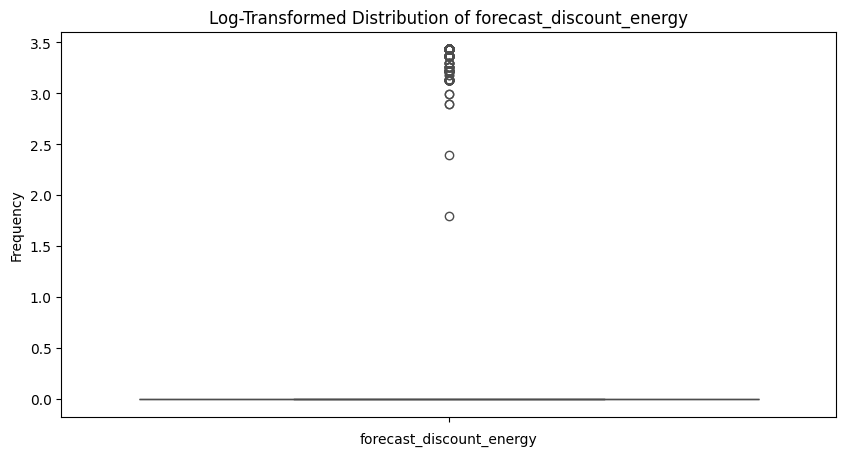

log transformed outlier count: 512


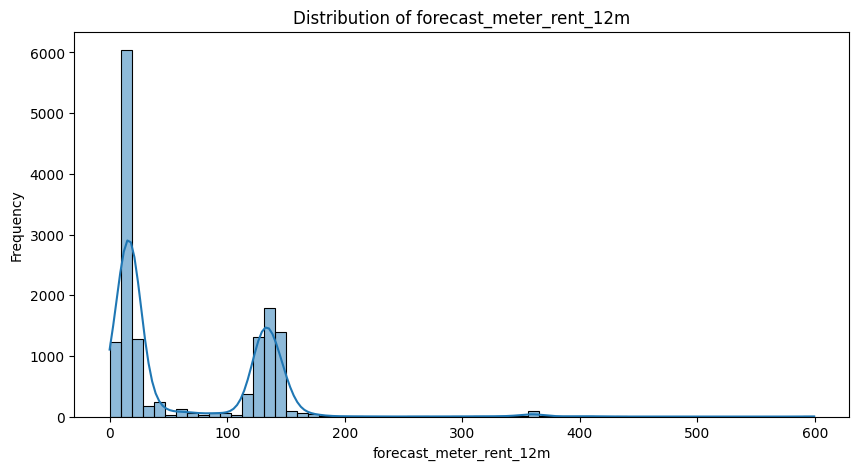

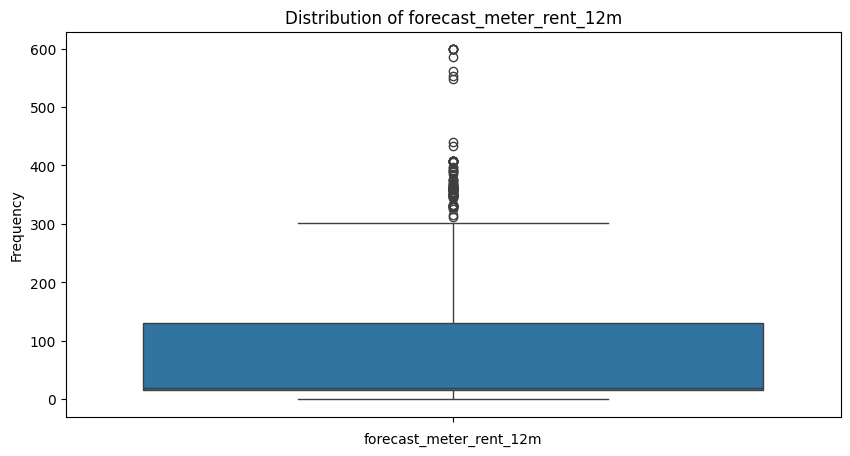

 outlier orignal count: 152


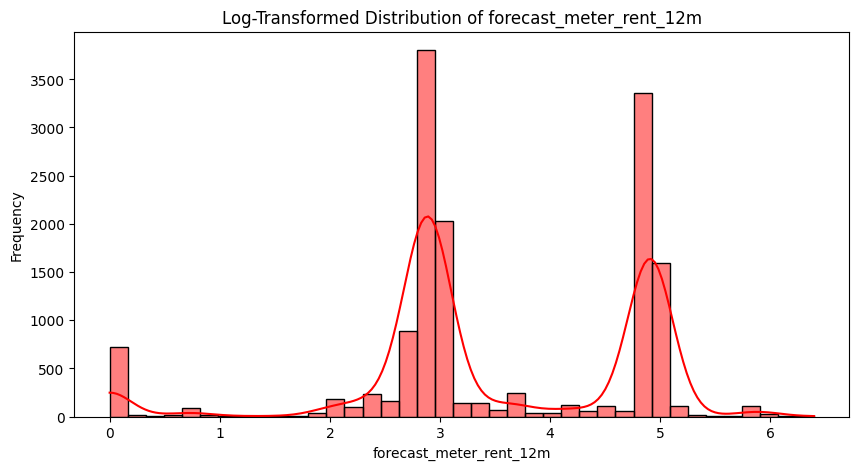

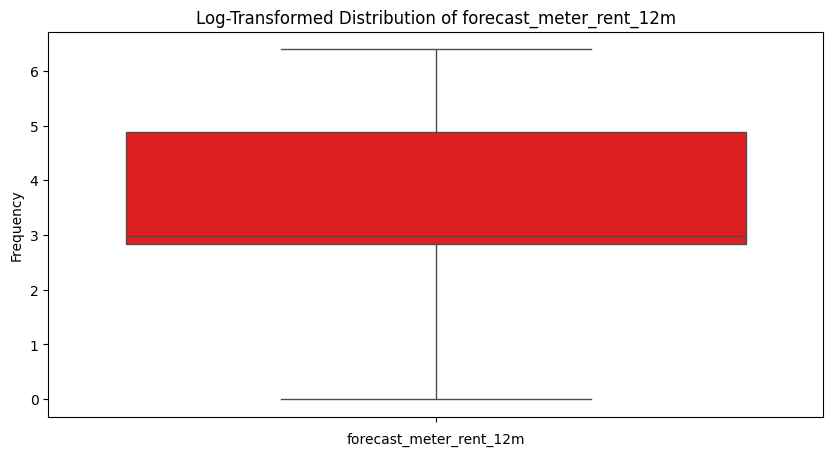

log transformed outlier count: 0


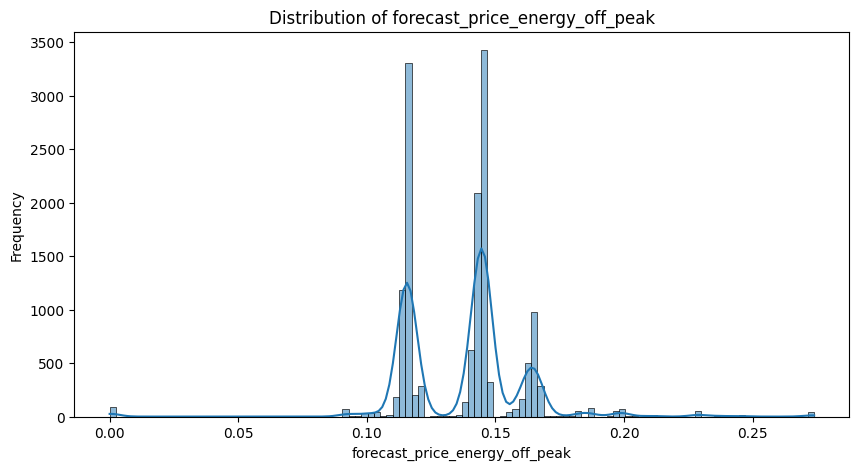

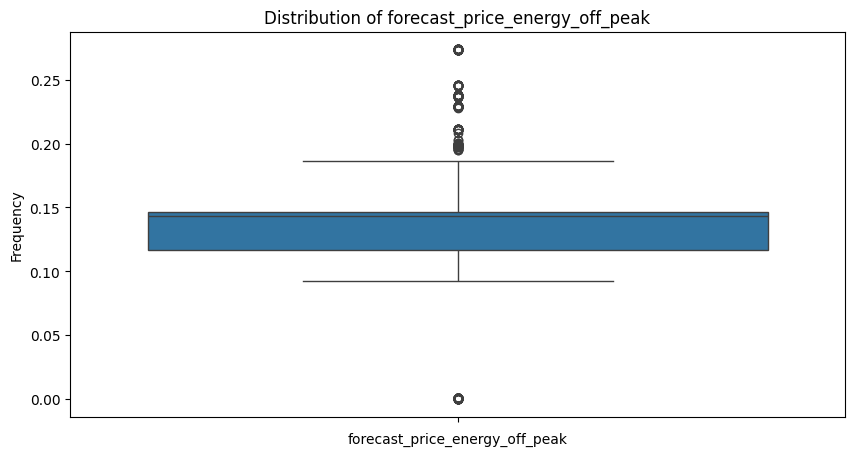

 outlier orignal count: 371


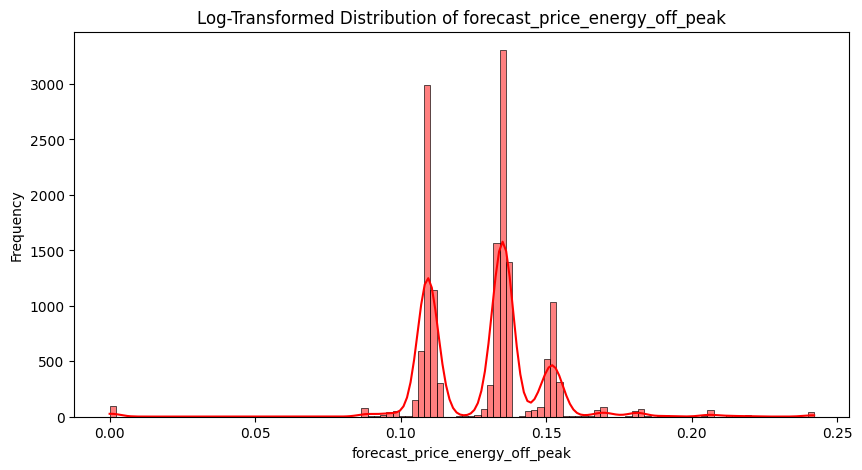

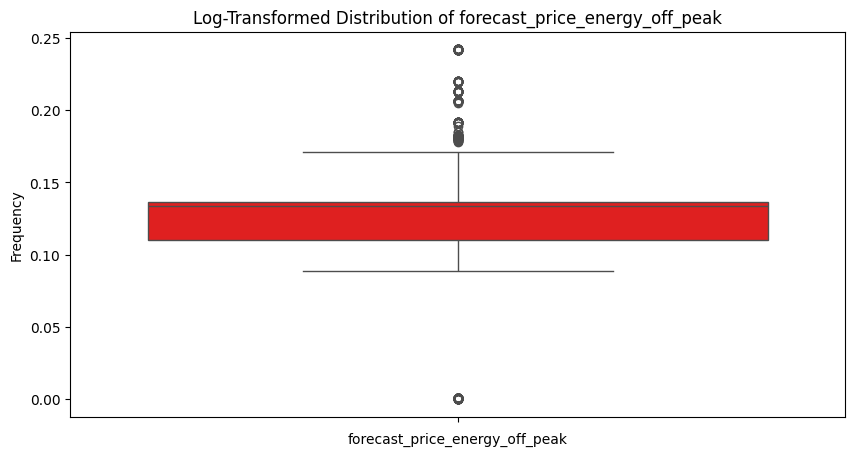

log transformed outlier count: 371


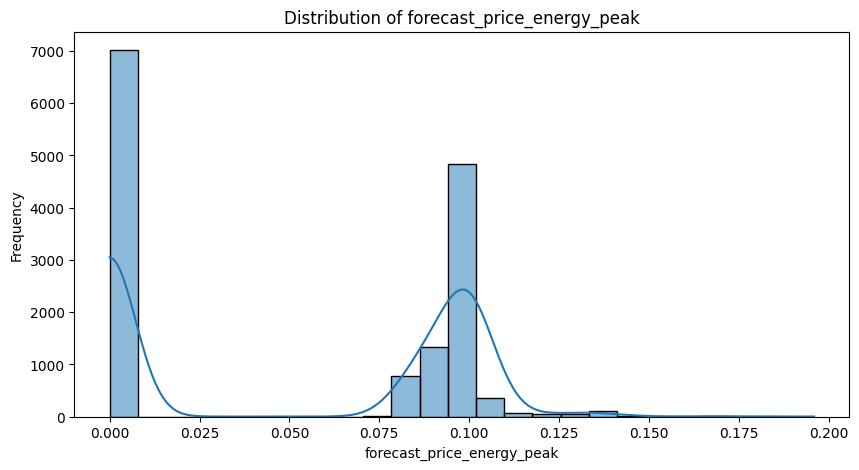

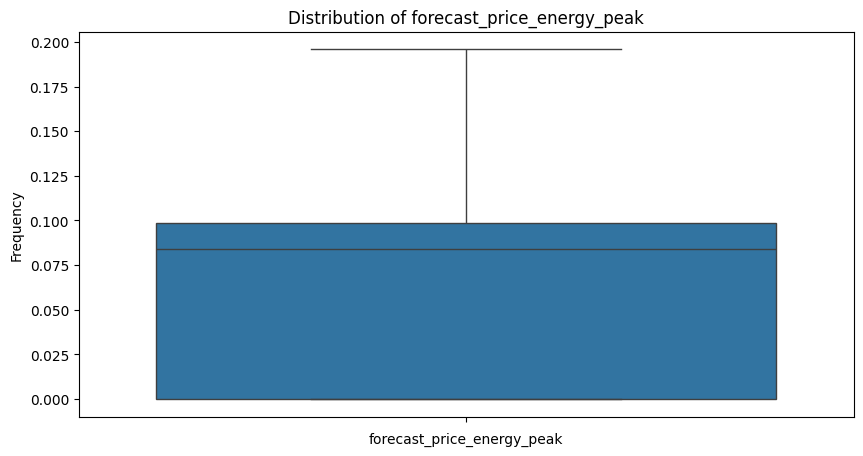

 outlier orignal count: 0


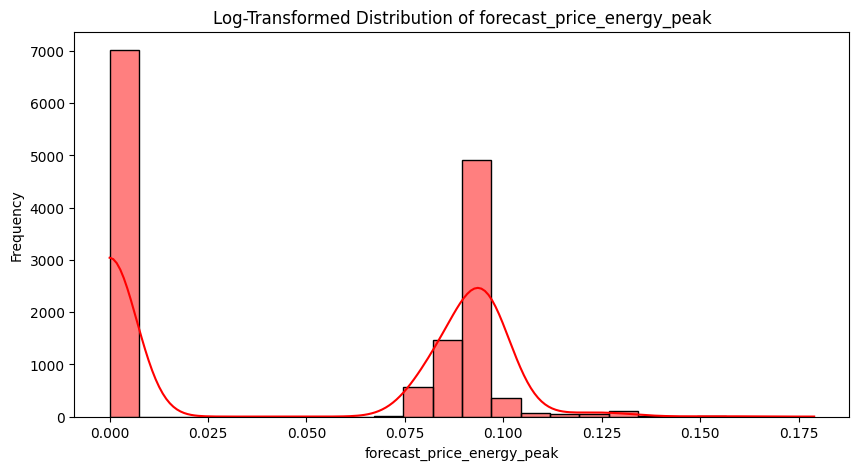

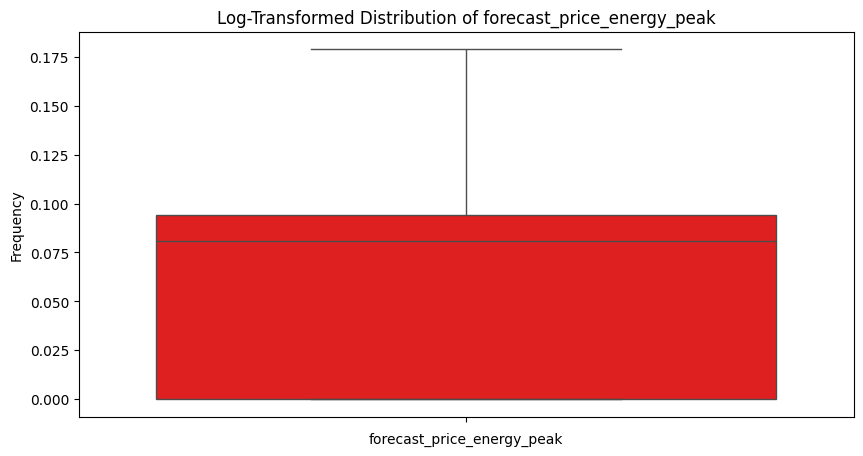

log transformed outlier count: 0


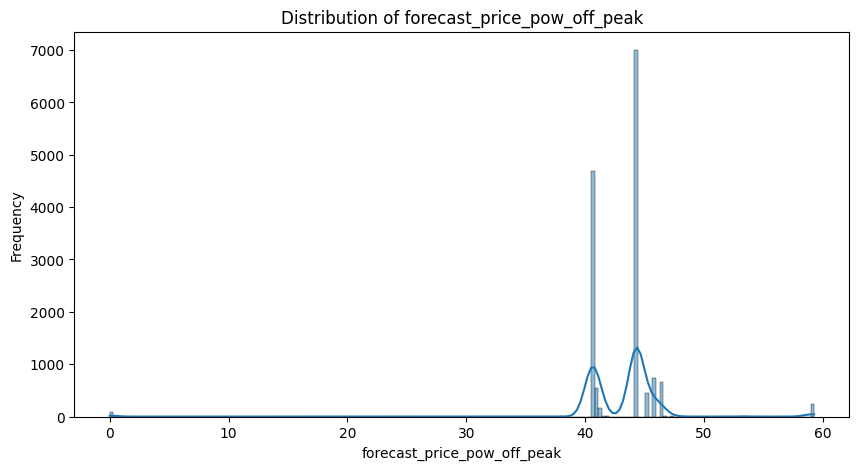

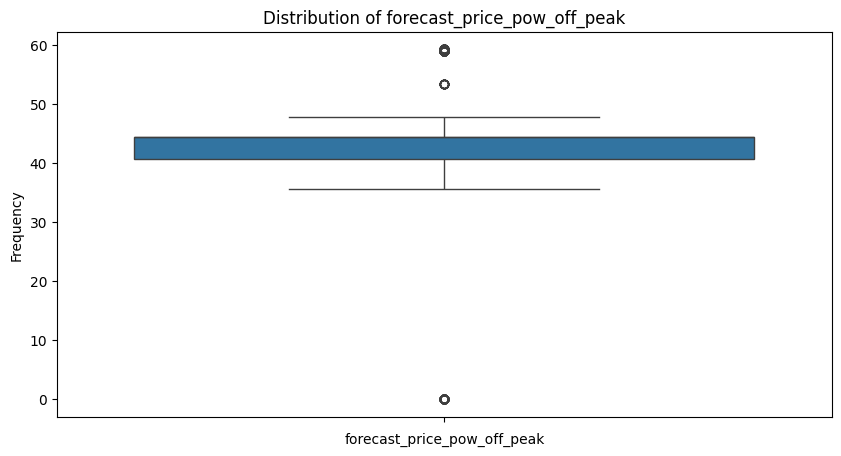

 outlier orignal count: 345


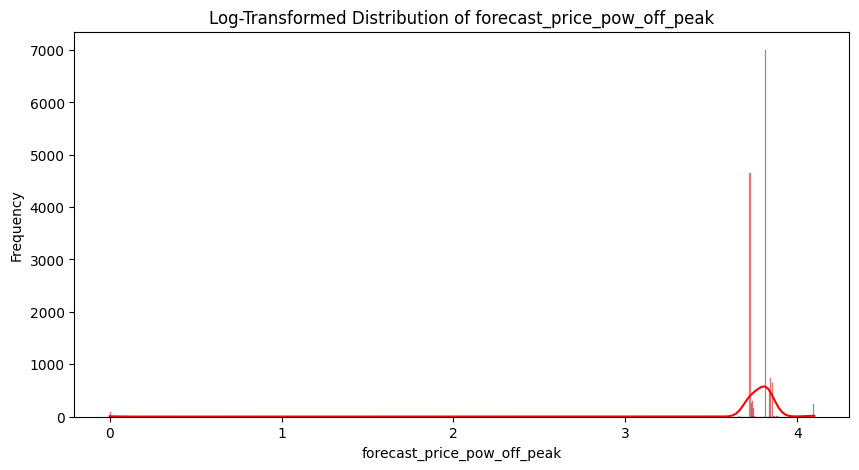

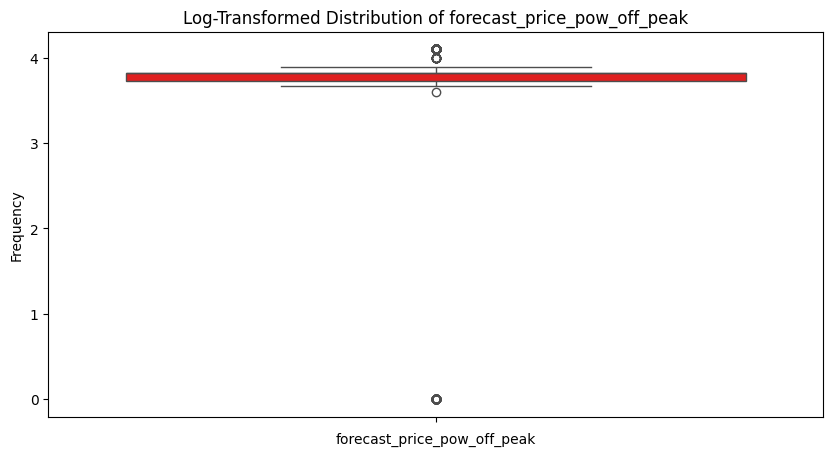

log transformed outlier count: 346


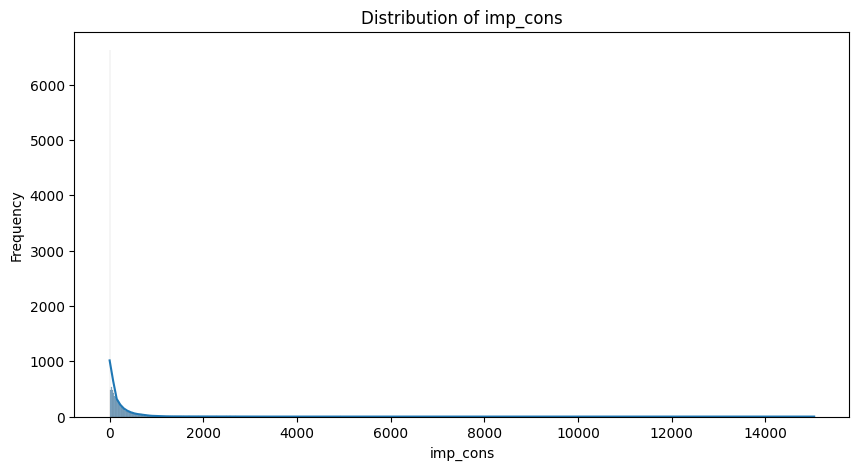

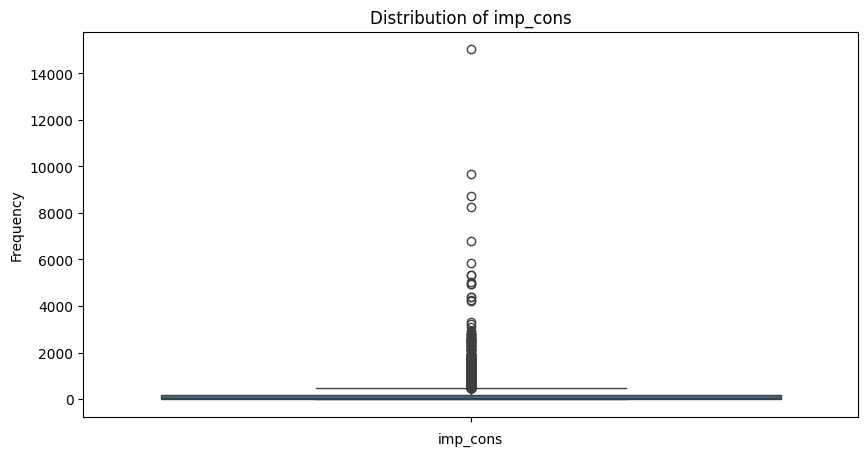

 outlier orignal count: 1215


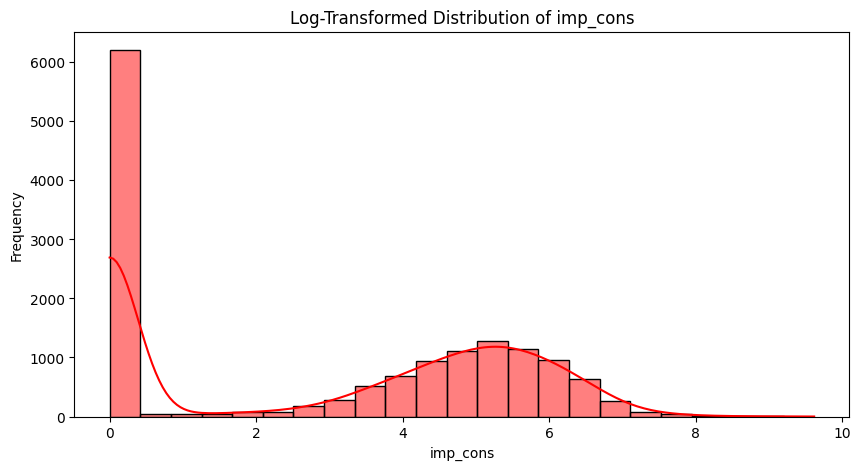

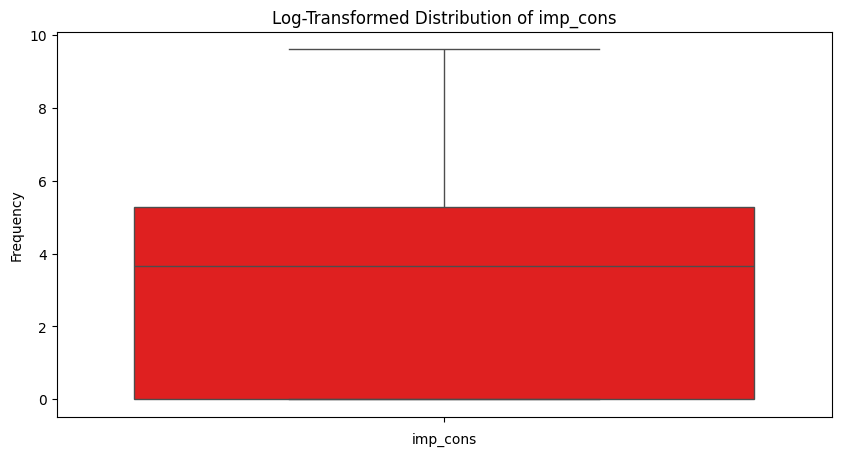

log transformed outlier count: 0


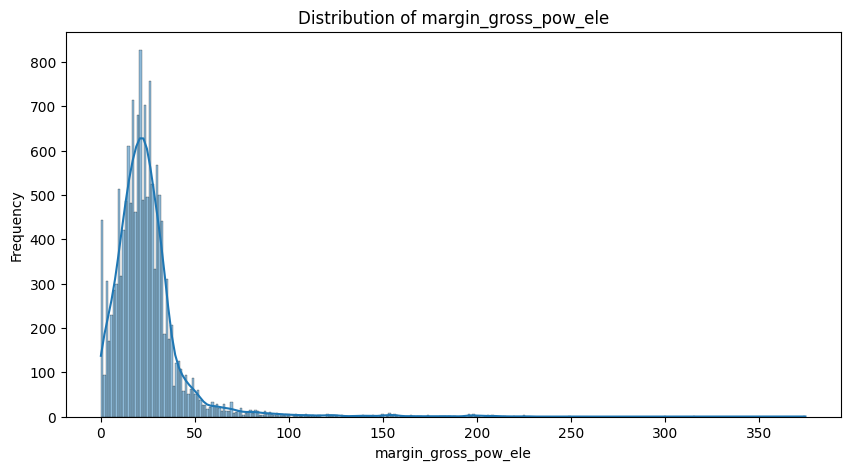

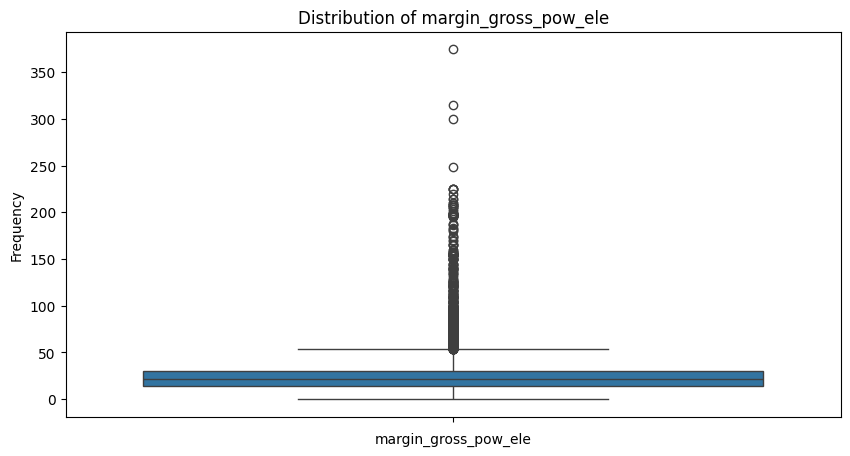

 outlier orignal count: 660


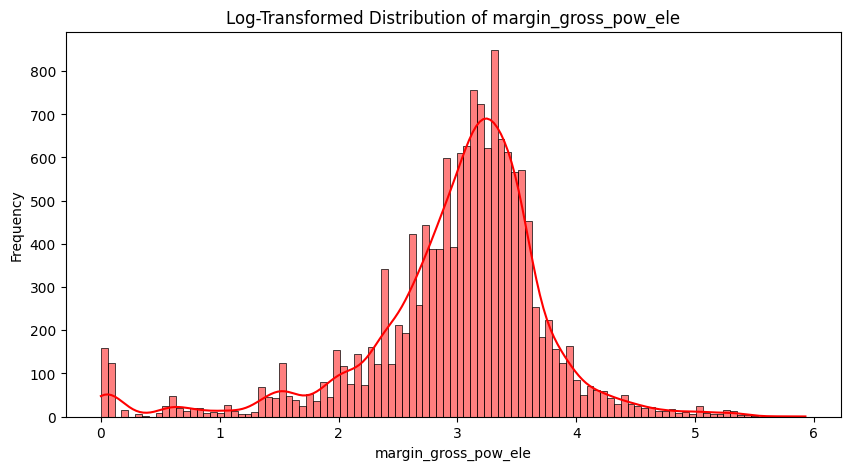

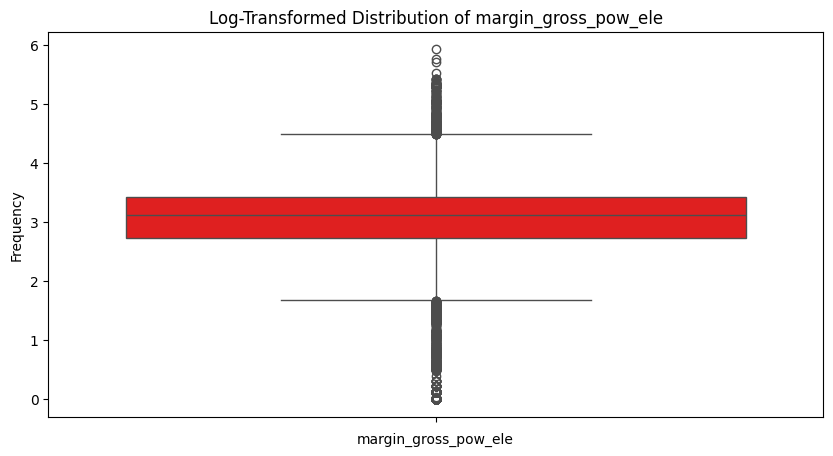

log transformed outlier count: 1139


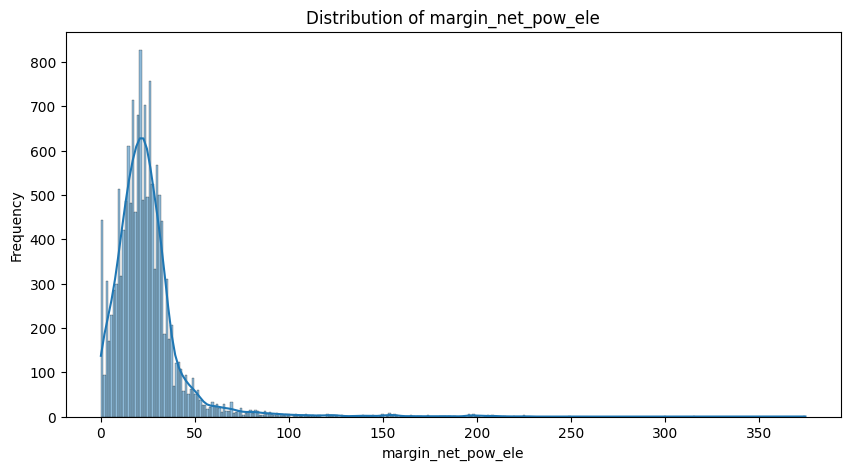

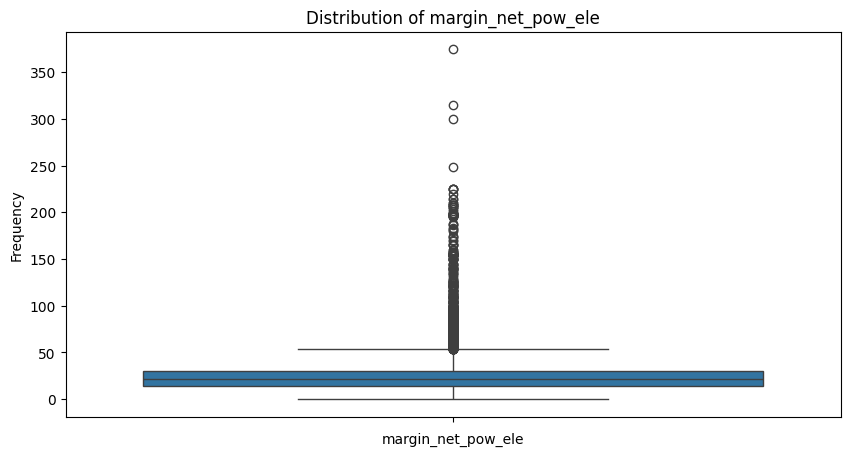

 outlier orignal count: 660


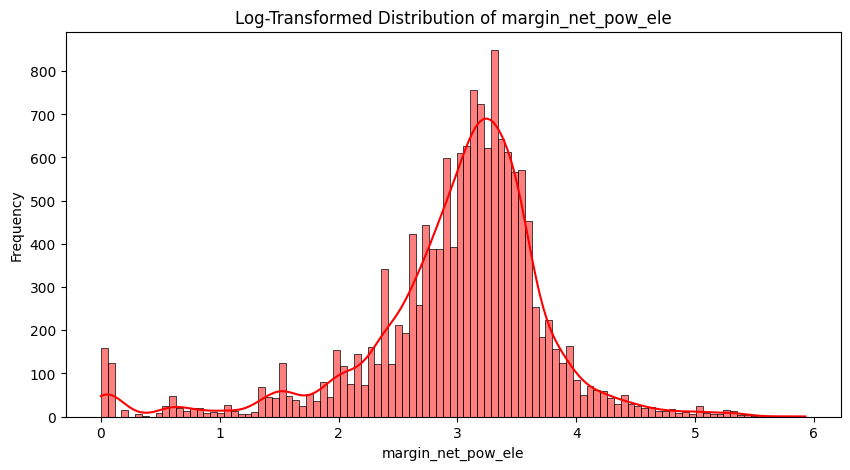

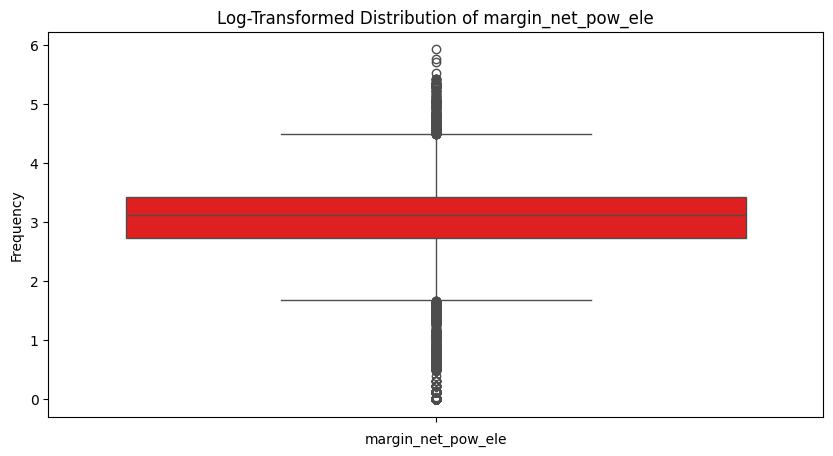

log transformed outlier count: 1139


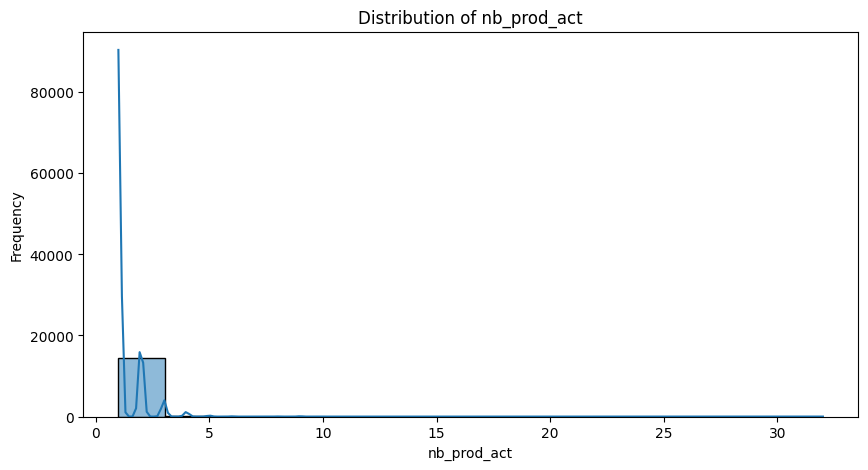

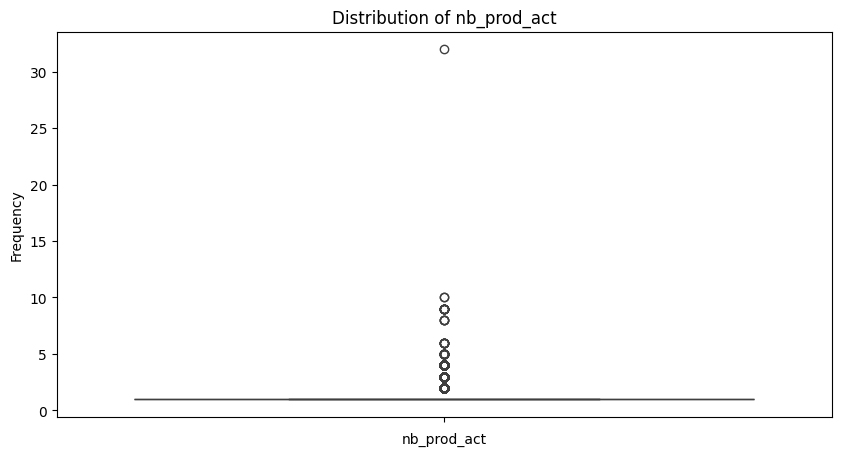

 outlier orignal count: 3175


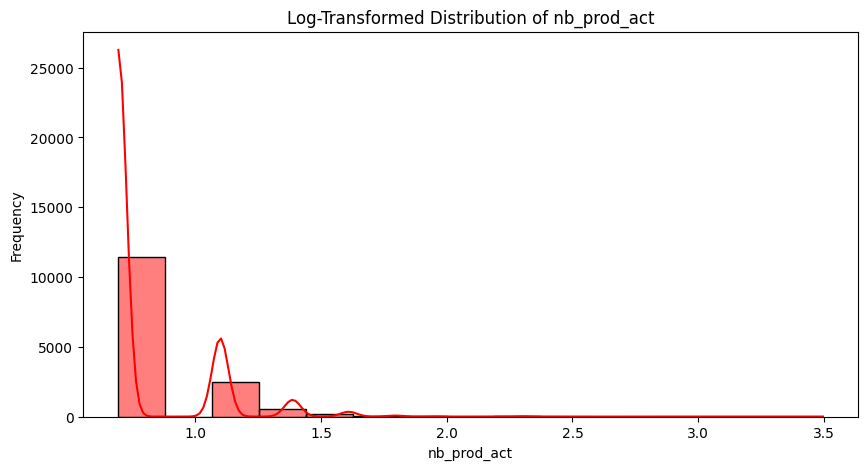

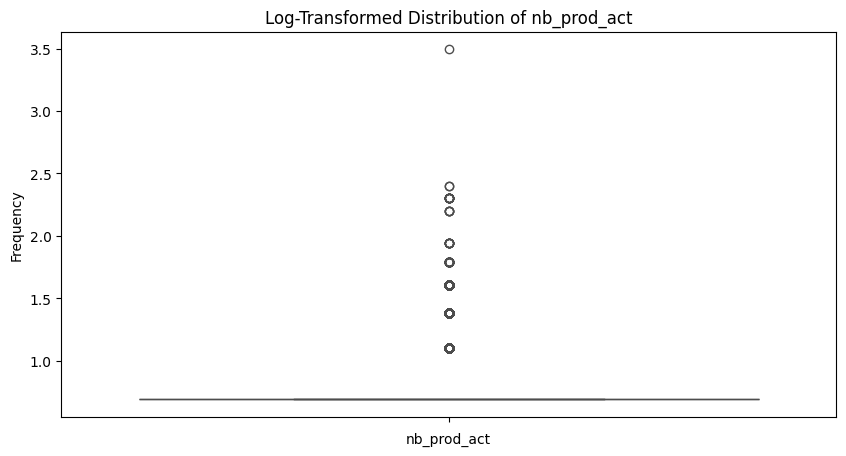

log transformed outlier count: 3175


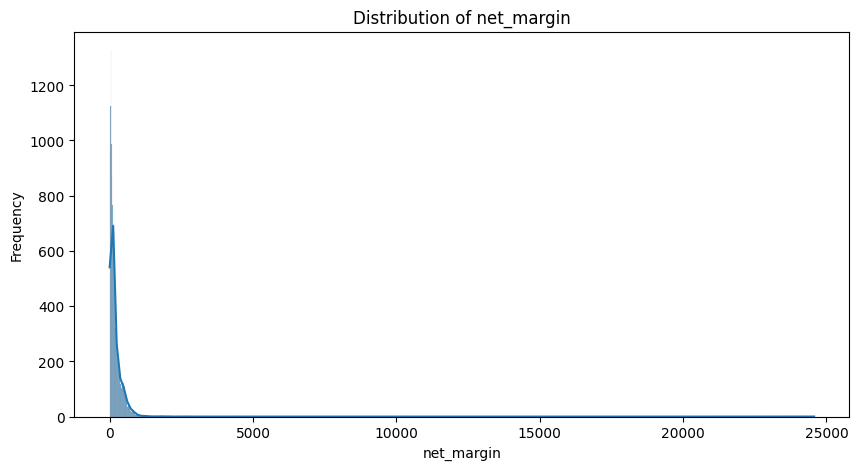

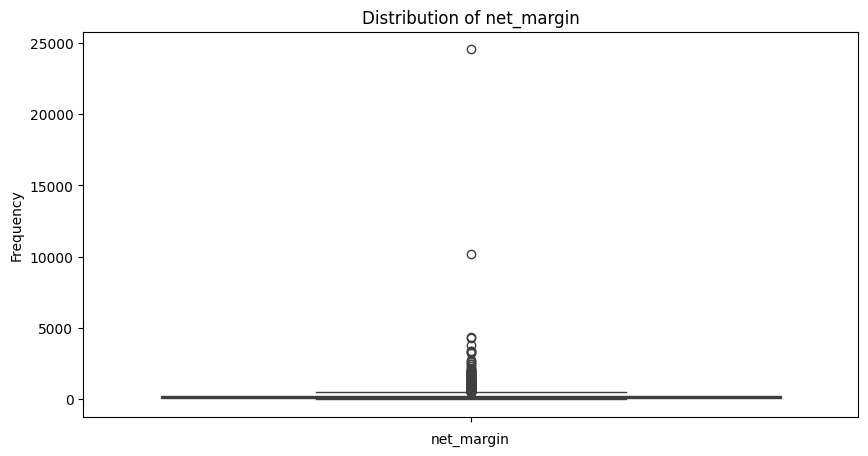

 outlier orignal count: 1022


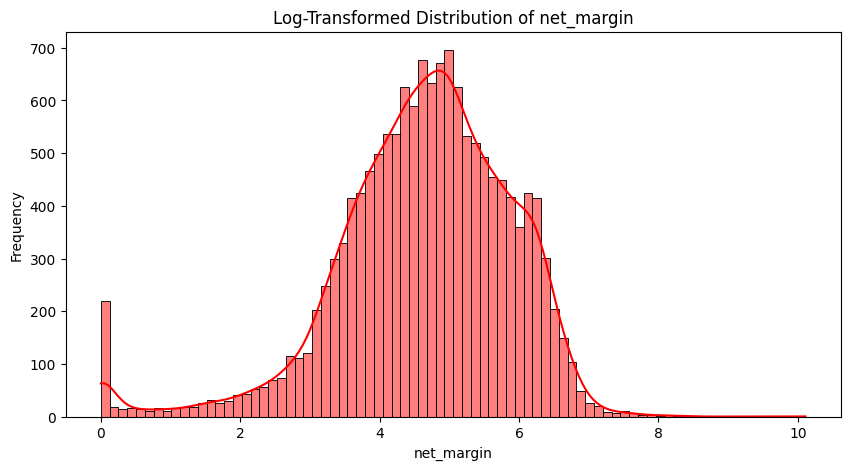

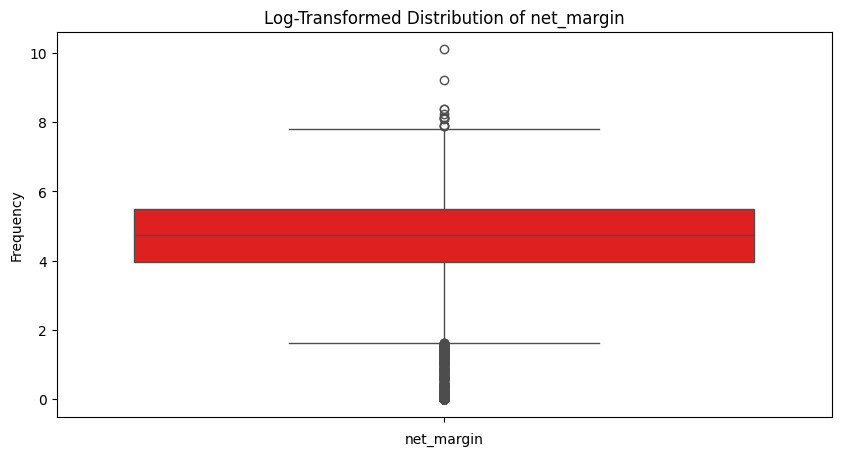

log transformed outlier count: 437


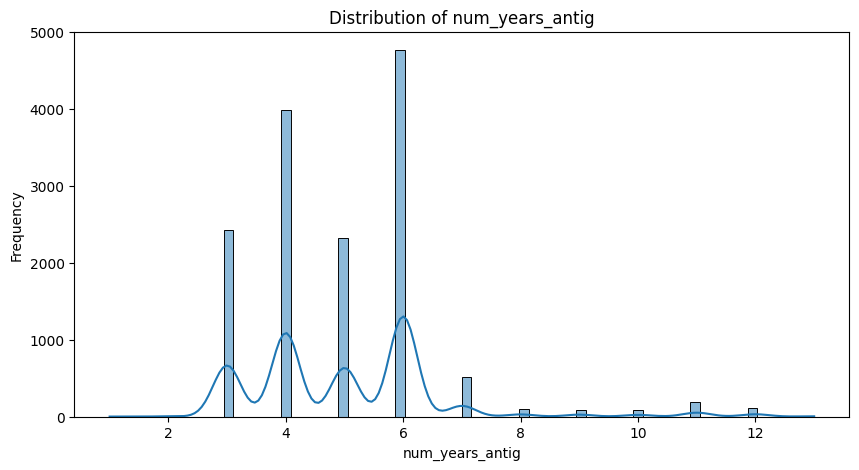

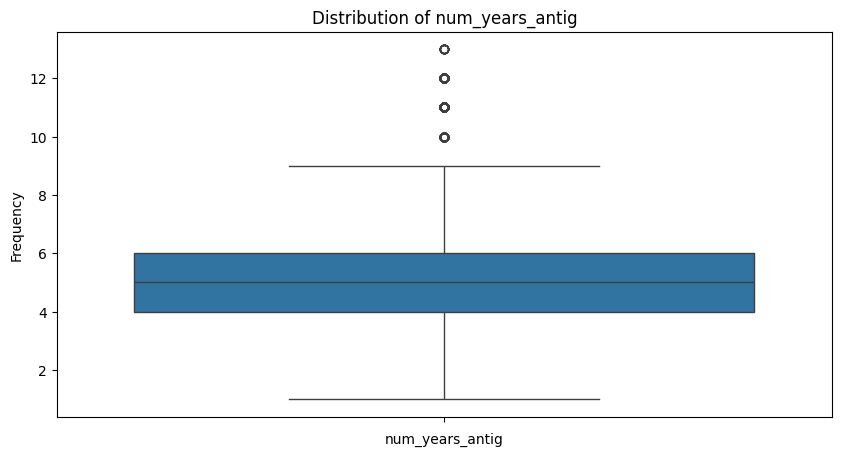

 outlier orignal count: 389


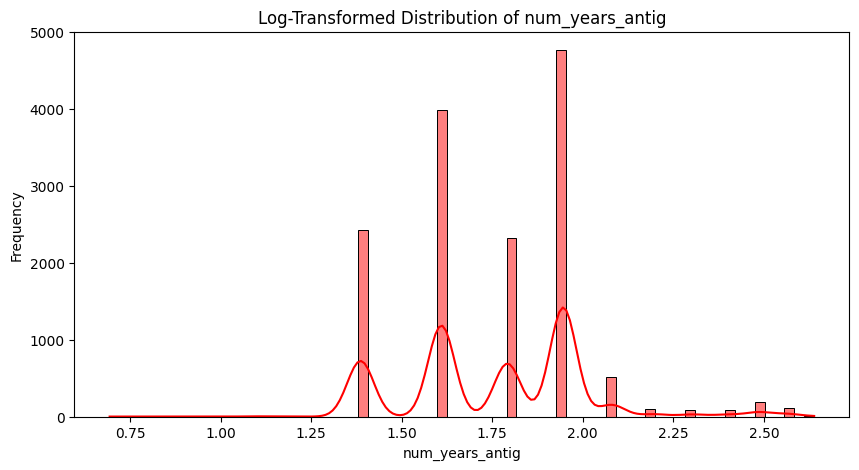

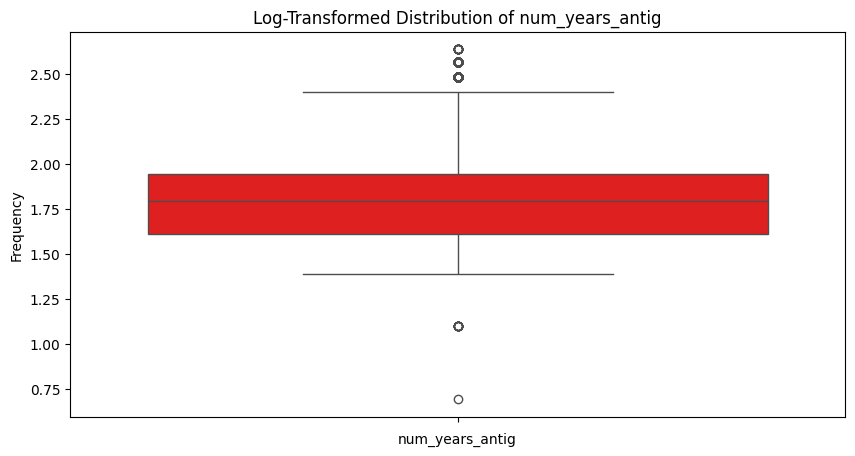

log transformed outlier count: 320


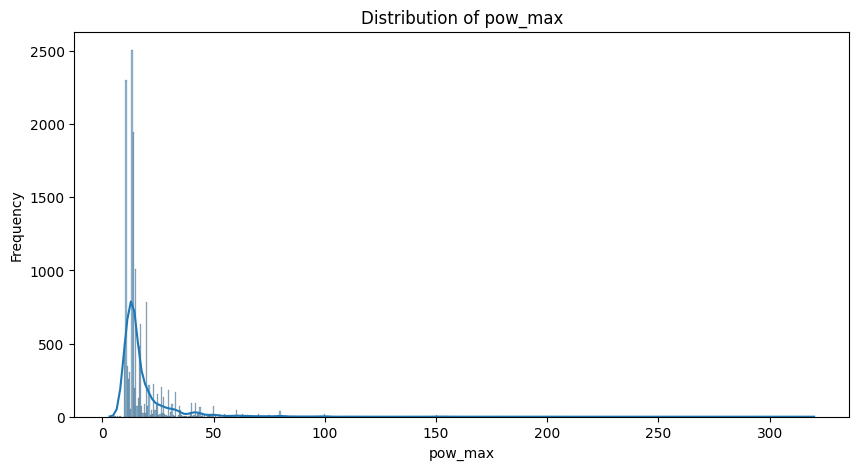

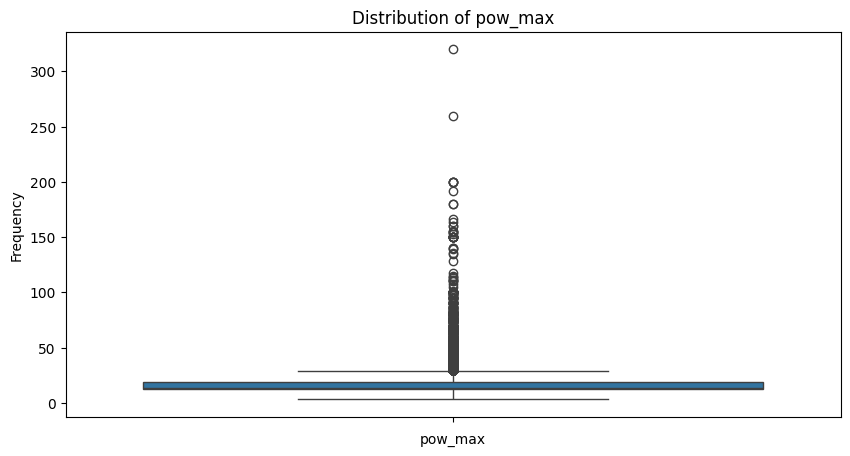

 outlier orignal count: 1535


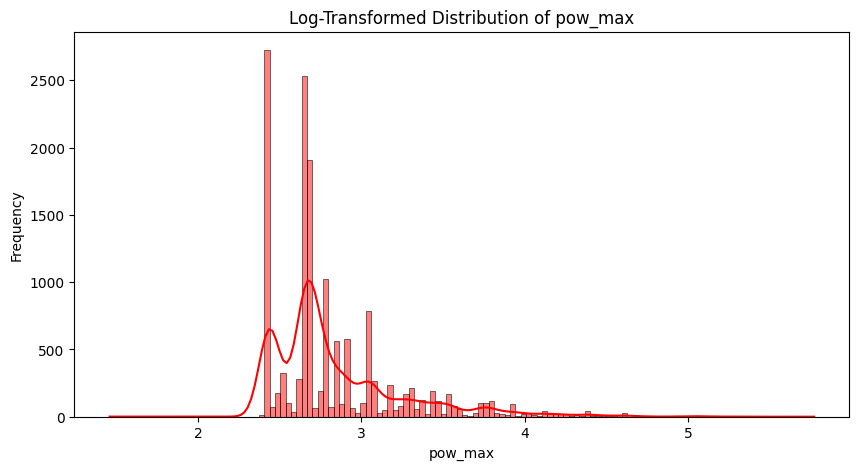

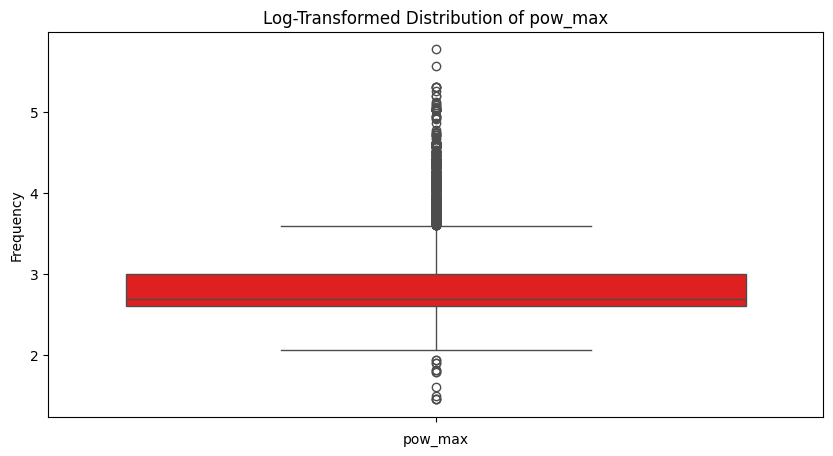

log transformed outlier count: 919
[('nb_prod_act', 3175, 3175), ('cons_gas_12m', 2612, 2612), ('margin_gross_pow_ele', 660, 1139), ('margin_net_pow_ele', 660, 1139), ('cons_12m', 2084, 1102), ('pow_max', 1535, 919), ('forecast_cons_12m', 1054, 582), ('forecast_discount_energy', 512, 512), ('net_margin', 1022, 437), ('forecast_price_energy_off_peak', 371, 371), ('forecast_price_pow_off_peak', 345, 346), ('num_years_antig', 389, 320), ('cons_last_month', 2051, 0), ('forecast_cons_year', 1298, 0), ('forecast_meter_rent_12m', 152, 0), ('forecast_price_energy_peak', 0, 0), ('imp_cons', 1215, 0)]


In [ ]:
#CLIENT NUMERICAL FEATURE DISTRIBUTIONS


#heatmap
plt.figure(figsize= (8,6))
correlation_matrix= client_df_copy.iloc[:,7:24].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt= '.2f')
plt.title(f'Correlation Heatmap for numerical features')
plt.show()



features_and_their_outliers=[]

#visualizations
for feature in client_df_copy.iloc[:,7:24]:
  #log transformation
  log_transformed_df= np.log1p(client_df_copy.iloc[:,7:24])
  #test for outliers via IQR




  #un transformed histogram
  plt.figure(figsize=(10,5))
  sns.histplot(client_df_copy[feature], kde=True)
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

  #boxplots
  plt.figure(figsize=(10,5))
  sns.boxplot(client_df_copy[feature])
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

 # print(f'{feature} un-transformed outlier count: {len(outliers)/len(client_df_copy)}')
  try:
    print(f' outlier orignal count: {outlier_count(client_df_copy, feature)}')
  except:
    print('error')
    outlier_count(client_df_copy, feature)


  features_and_their_outliers.append((feature, outlier_count(client_df_copy, feature), outlier_count(log_transformed_df, feature)))
  features_and_their_outliers.sort(key=lambda x: x[2], reverse=True)
  # print(features_and_their_outliers)


  #log-transformed histogram
  plt.figure(figsize=(10,5))
  sns.histplot(log_transformed_df[feature], kde=True, color='red')
  plt.title(f'Log-Transformed Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

  #boxplots
  plt.figure(figsize=(10,5))
  sns.boxplot(log_transformed_df[feature], color='red')
  plt.title(f'Log-Transformed Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

 #print(f'{feature} Log-Transformed outlier count: {len(outliers)/len(client_df_copy)}')
  try:
    print(f'log transformed outlier count: {outlier_count(log_transformed_df, feature)}')
  except:
    print('error')


print(features_and_their_outliers)




<mark>INSIGHT 4:
<div><br><mark>
features related to consumption over X amount of time & features related to consumption of gas vs. consumption of electricity show sings of multicollinearity

<div><br><mark>
current paid consumption and forecasted consumption of electricty show high correlation

<div><br><mark>
unexpectedly, net margin (in dollars?) has a high correlation with the forecasted electricity consumption for the next 12 months / (and slightly less so for the next calender year)

<div><br><mark>
subscribed power has high correlation with forcasted consumption over the next 12 months (and slightly less so for the next calender year) (and high correlation with meter rent)

<div><br><mark>
margin gross and margin net are overly highly correlated, indicating multi collinearity


<div><br><mark>
Most numerical features tend to decrease in outliers and skewness as a result of logarithmic transformations

In [ ]:
for feature in client_df_copy.iloc[:,3:7]:
  #convert to date time
  client_df_copy[feature]= pd.to_datetime(client_df_copy[feature])

In [ ]:
#print(client_df_copy.iloc[:,3:7].dtypes)
print(client_df_copy['date_activ'].dtype)

datetime64[ns]


In [ ]:
#select time based features in df
client_date_cols= client_df_copy.iloc[:,3:7]


#create new feature(length of time in contract from the start and end date features)
client_df_copy['contract_length_days'] = (client_df_copy['date_end']- client_df_copy['date_activ']).dt.days
client_df_copy['days_between_mod_and_end'] = (client_df_copy['date_end']- client_df_copy['date_modif_prod']).dt.days

Text(0, 0.5, 'Frequency')

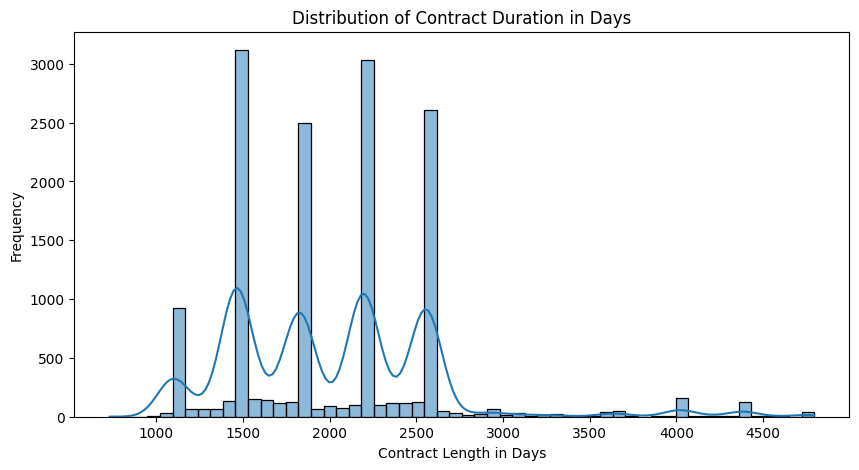

In [ ]:
# client date features distributions
plt.figure(figsize=(10,5))
sns.histplot(client_df_copy['contract_length_days'], kde=True)
plt.title(f'Distribution of Contract Duration in Days')
plt.xlabel('Contract Length in Days')
plt.ylabel('Frequency')

<mark>INSIGHT 5:

contract dates tend to last around X year points (~365 days)

Text(0.5, 1.0, 'Distribution of Days between Modification and End of Contract')

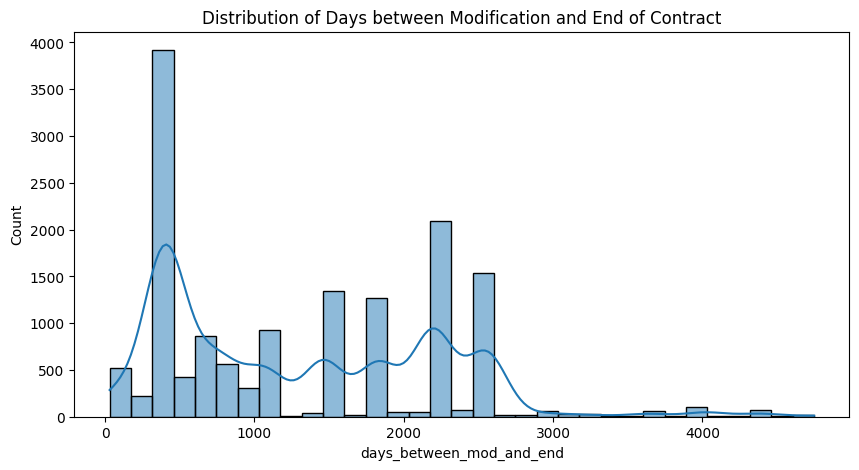

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(client_df_copy['days_between_mod_and_end'], kde=True)
plt.title(f'Distribution of Days between Modification and End of Contract')

<mark>INSIGHT 6:

most often, around 300 days, is the amount of time between the last product modification is done and the end of a clients contract

In [ ]:
client_date_cols.head()

date_activ   date_end date_modif_prod date_renewal
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09

# Price data

In [ ]:
price_df.head()

id  price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745  2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745  2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745  2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745  2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745  2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [ ]:
#count the number ouf outliers in frice features in price df
for feature in price_df.columns[2:8]:
  count_outliers= outlier_count(price_df.iloc[:,2:8], feature)
  print(f'{feature}: {count_outliers}')


price_off_peak_var: 5633
price_peak_var: 0
price_mid_peak_var: 0
price_off_peak_fix: 10452
price_peak_fix: 0
price_mid_peak_fix: 0


all price features have less than 5% of outliers, which is acceptable and thus doesnt require a transformation to reduce outlier count

In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [ ]:
price_df['price_date']=pd.to_datetime(price_df['price_date'])

In [ ]:
price_df['price_date'].dtypes

dtype('<M8[ns]')

In [ ]:
price_df.describe()

price_date  price_off_peak_var  price_peak_var  \
count                         193002       193002.000000   193002.000000   
mean   2015-06-16 12:50:49.933161216            0.141027        0.054630   
min              2015-01-01 00:00:00            0.000000        0.000000   
25%              2015-04-01 00:00:00            0.125976        0.000000   
50%              2015-07-01 00:00:00            0.146033        0.085483   
75%              2015-10-01 00:00:00            0.151635        0.101673   
max              2015-12-01 00:00:00            0.280700        0.229788   
std                              NaN            0.025032        0.049924   

       price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
count       193002.000000       193002.000000   193002.000000   
mean             0.030496           43.334477       10.622875   
min              0.000000            0.000000        0.000000   
25%              0.000000           40.728885        0.000000   
50%              0.000000           44.266930        0.000000   
75%              0.072558           44.444710       24.339581   
max              0.114102           59.444710       36.490692   
std              0.036298            5.410297       12.841895   

       price_mid_peak_fix  
count       193002.000000  
mean             6.409984  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%             16.226389  
max             17.458221  
std              7.773592

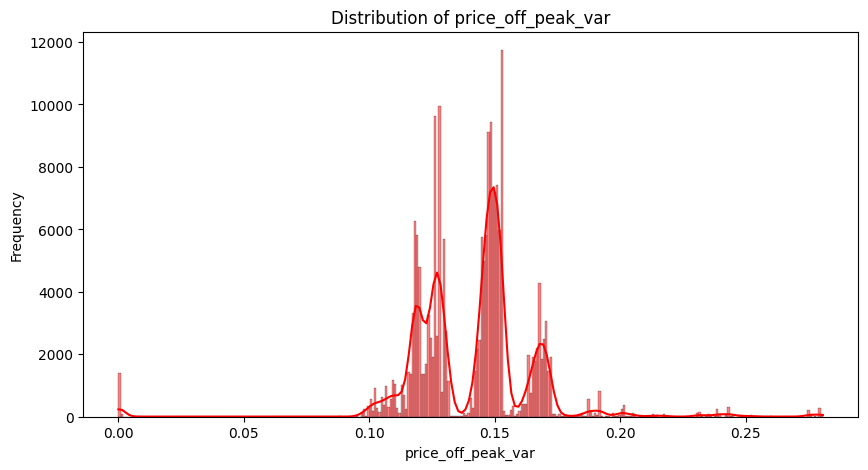

5633


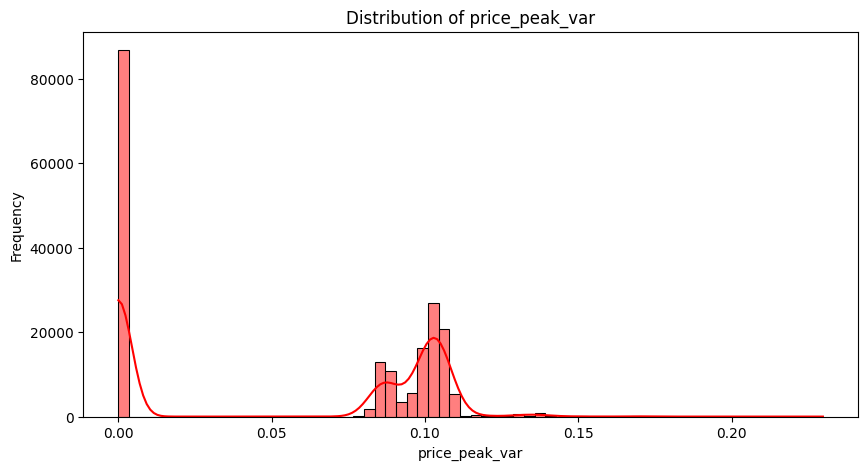

0


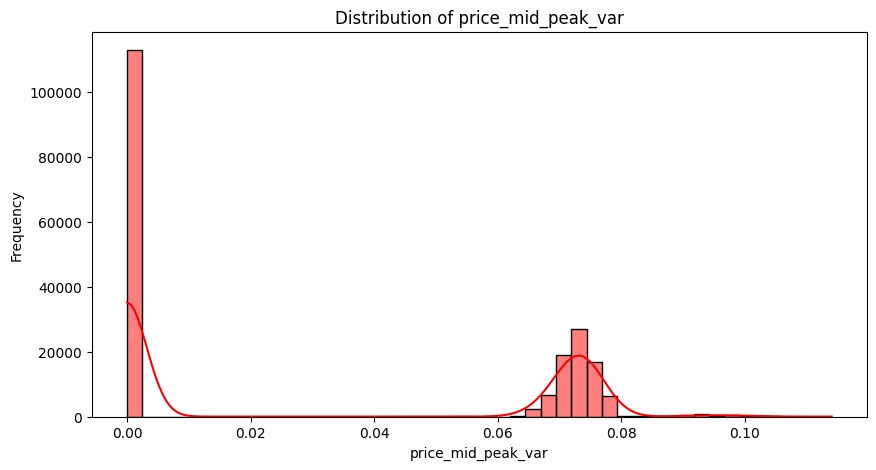

0


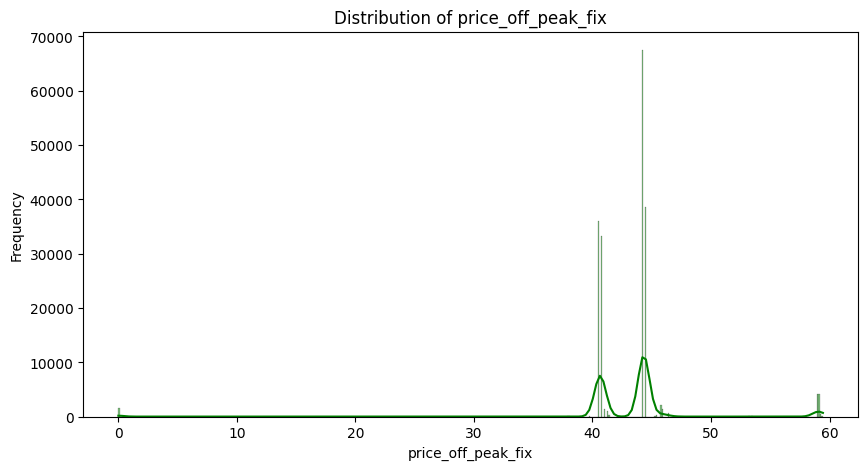

10452


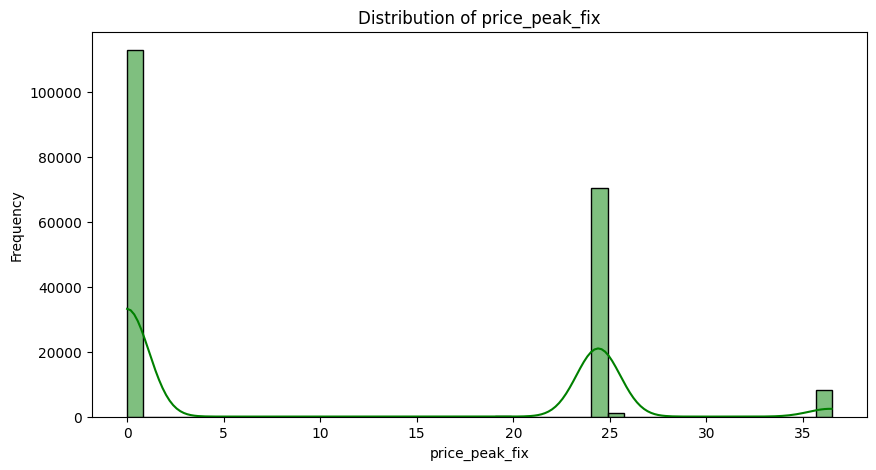

0


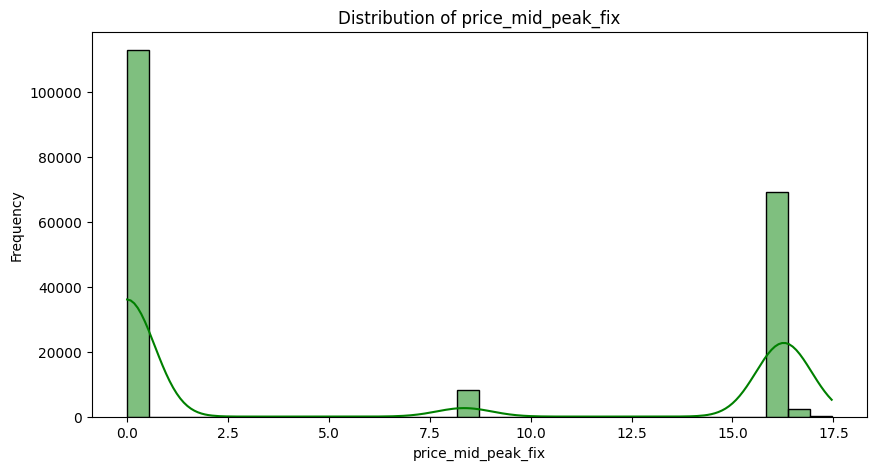

0


In [ ]:
for i, feature in enumerate(price_df.columns[2:8]):
  '''
  i think electricty costs are Kilo watts per hour and are charged based on total consumption
  while 'power' refers to demand charges (kilo watts demanded at a given moment (not total),
  this demand charge is seperately charged (in $/Kilowatt) due to the capacity of teh elec grid at a given moment )
  '''
  if i in [0,1,2]: #these are 'energy prices' (not power prices)
    plt.figure(figsize=(10,5))
    sns.histplot(price_df[feature], kde=True, color='red')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
    print(outlier_count(price_df, feature))
  else:#these are the 'power prices' or demand charges
    plt.figure(figsize=(10,5))
    sns.histplot(price_df[feature], kde=True, color='green')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
    print(outlier_count(price_df, feature))




INSIGHT 7:

electricity prices unexpectedly go down during peak times on avg

power prices (demand charges?) unexpectedly go down during peak times on avg as well.

In [ ]:
#merge price and client data
client_df_consumption_copy=client_df_copy.iloc[:, 7:13].copy()
np.log_transformed_df= np.log1p(client_df_consumption_copy)
merged_df = pd.merge(left=client_df_consumption_copy, right=price_df.iloc[:, 2:8], left_index=True, right_index=True)
merged_df.head()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0         0         54946                0               0.00   
1      4660             0                0             189.95   
2       544             0                0              47.96   
3      1584             0                0             240.04   
4      4425             0              526             445.75   

   forecast_cons_year  forecast_discount_energy  price_off_peak_var  \
0                   0                       0.0            0.151367   
1                   0                       0.0            0.151367   
2                   0                       0.0            0.151367   
3                   0                       0.0            0.149626   
4                 526                       0.0            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14606 entries, 0 to 14605
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cons_12m                  14606 non-null  int64  
 1   cons_gas_12m              14606 non-null  int64  
 2   cons_last_month           14606 non-null  int64  
 3   forecast_cons_12m         14606 non-null  float64
 4   forecast_cons_year        14606 non-null  int64  
 5   forecast_discount_energy  14606 non-null  float64
 6   price_off_peak_var        14606 non-null  float64
 7   price_peak_var            14606 non-null  float64
 8   price_mid_peak_var        14606 non-null  float64
 9   price_off_peak_fix        14606 non-null  float64
 10  price_peak_fix            14606 non-null  float64
 11  price_mid_peak_fix        14606 non-null  float64
dtypes: float64(8), int64(4)
memory usage: 1.4 MB


/tmp/ipython-input-1756087669.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,5))


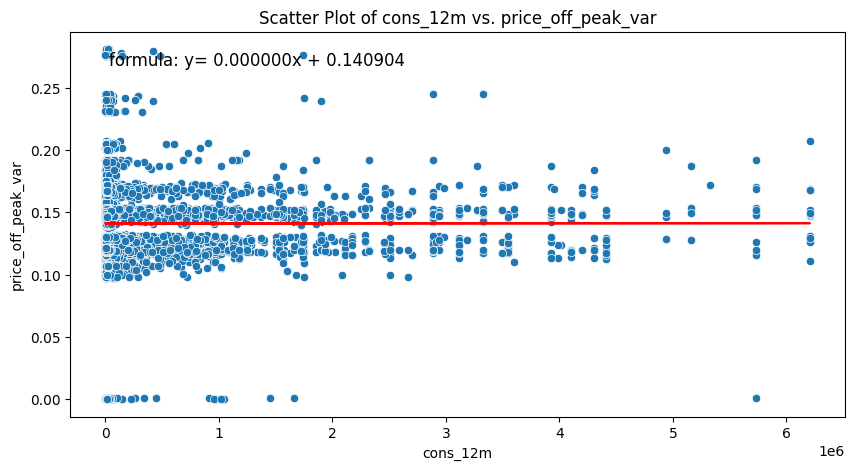

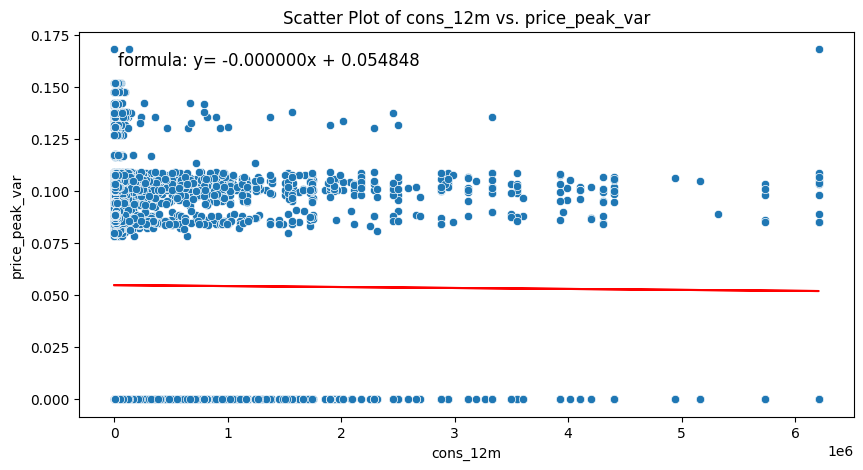

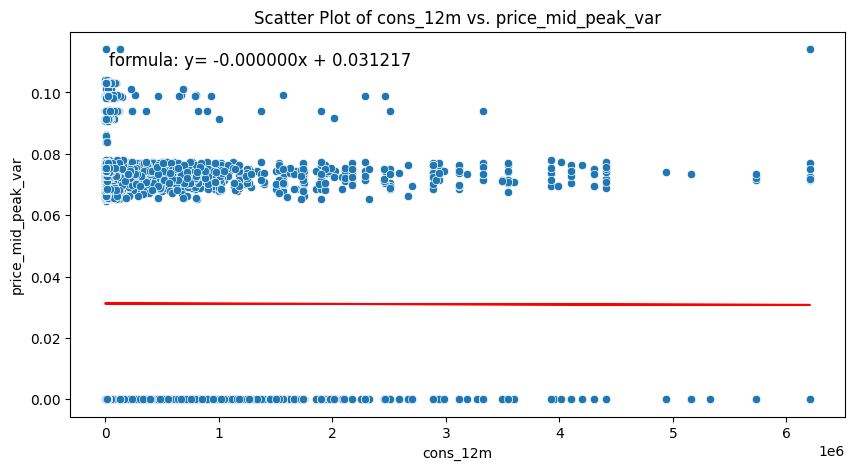

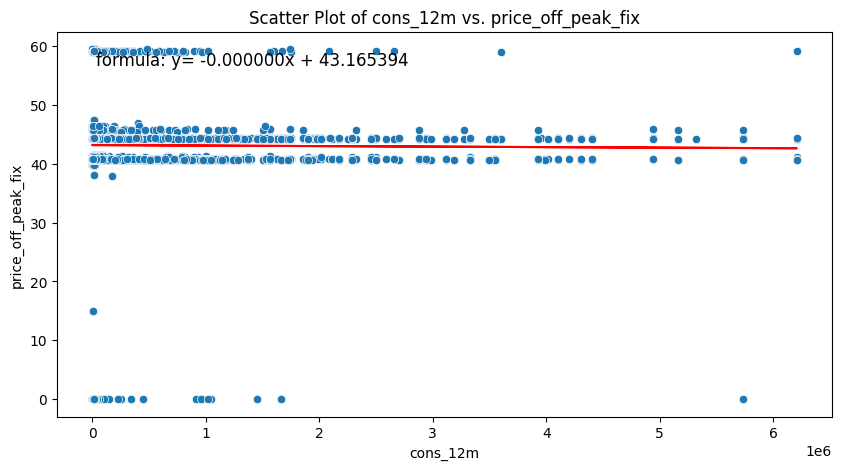

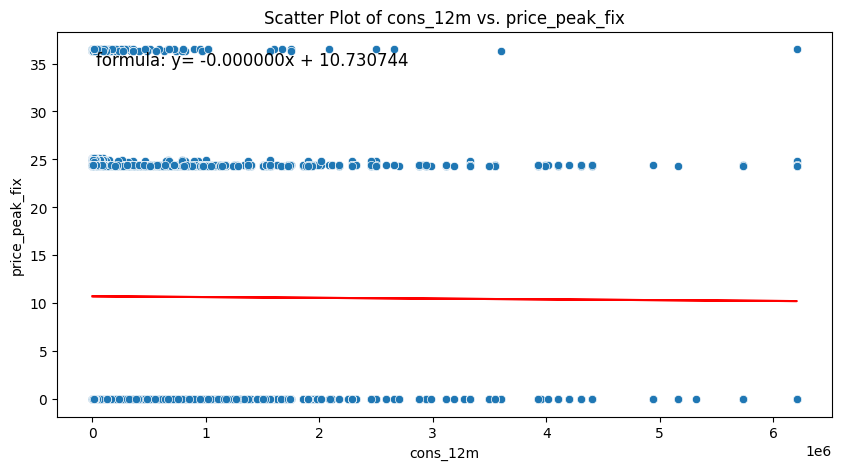

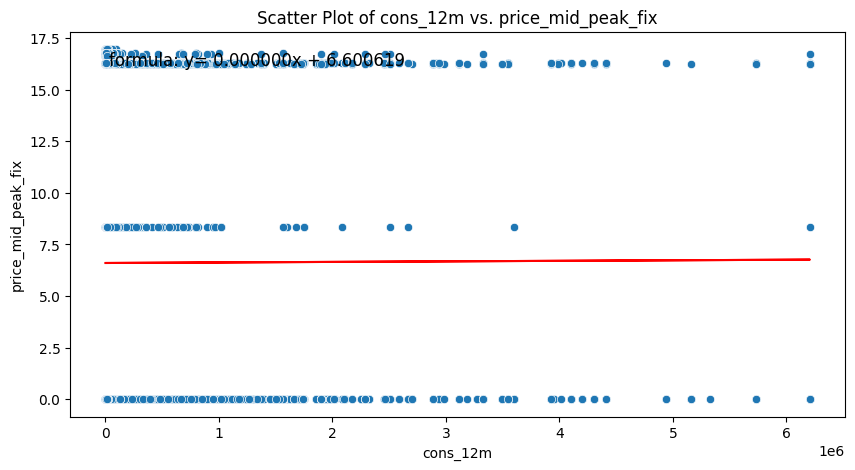

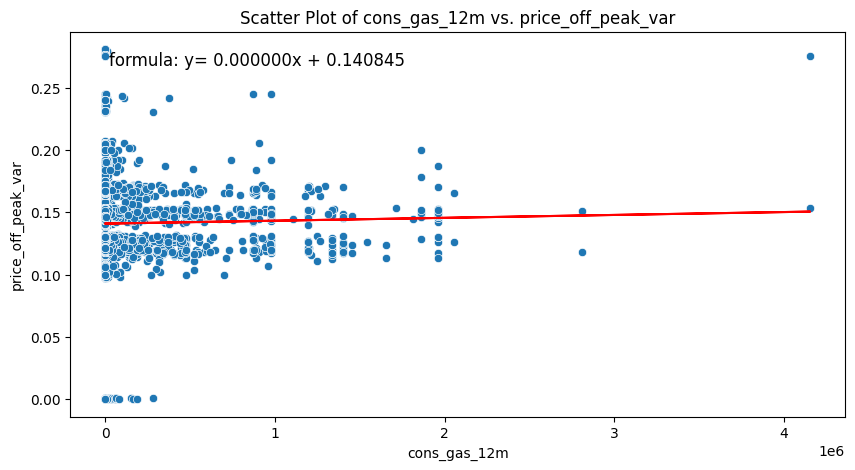

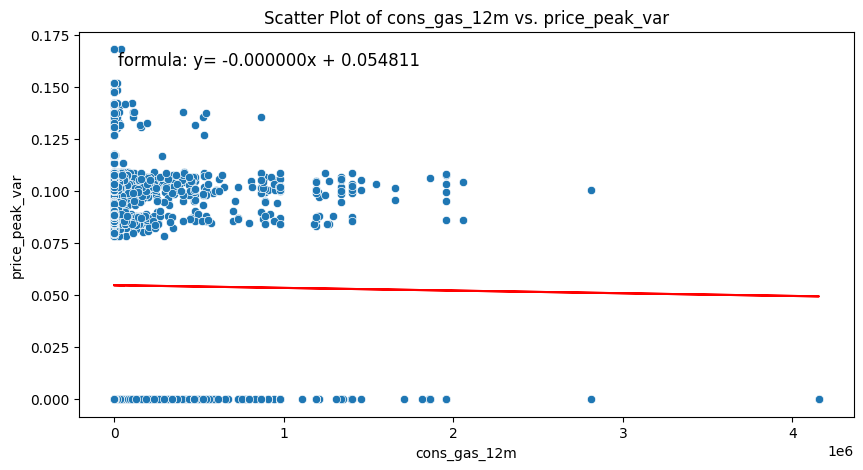

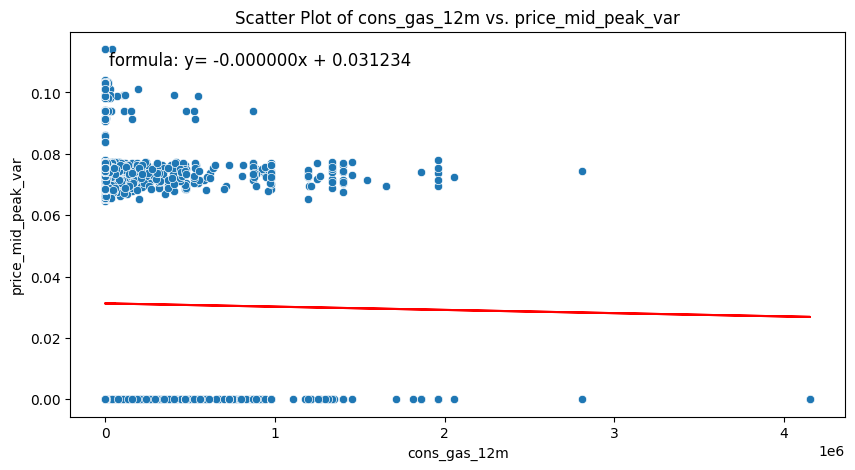

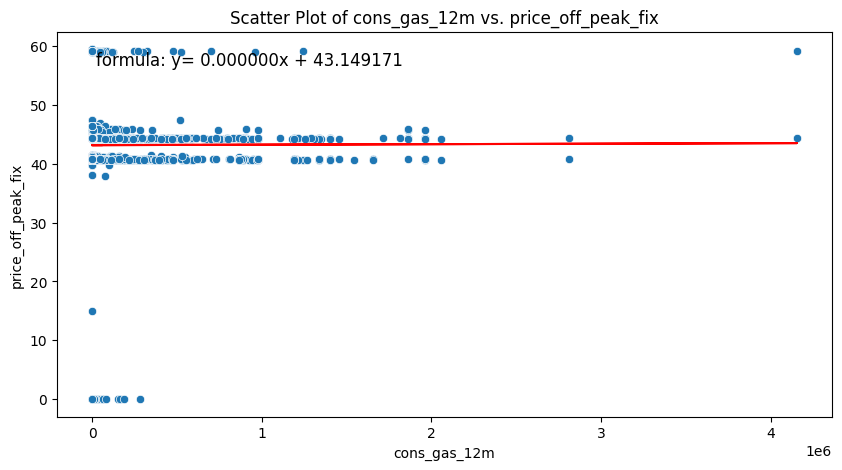

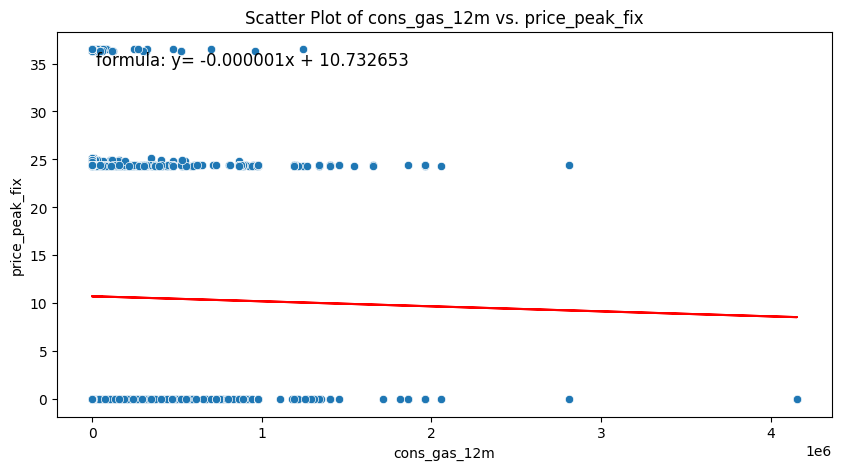

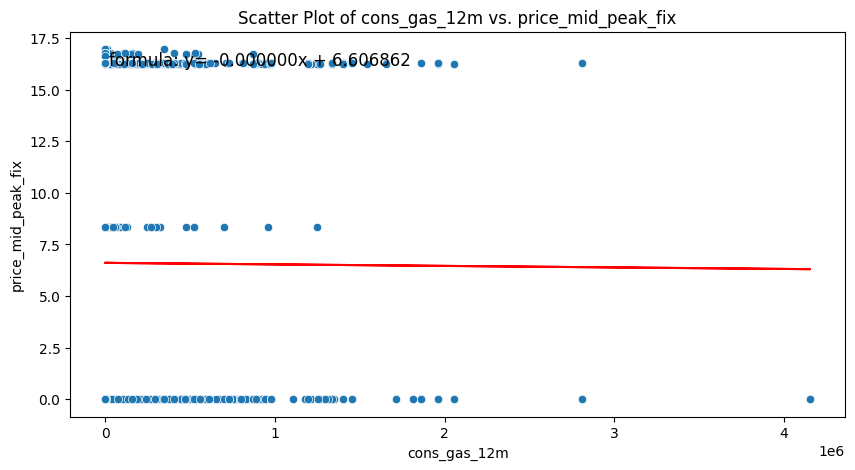

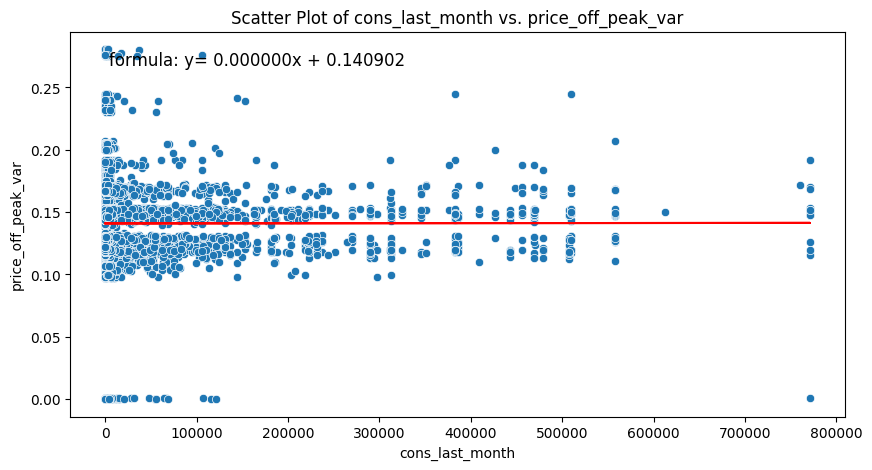

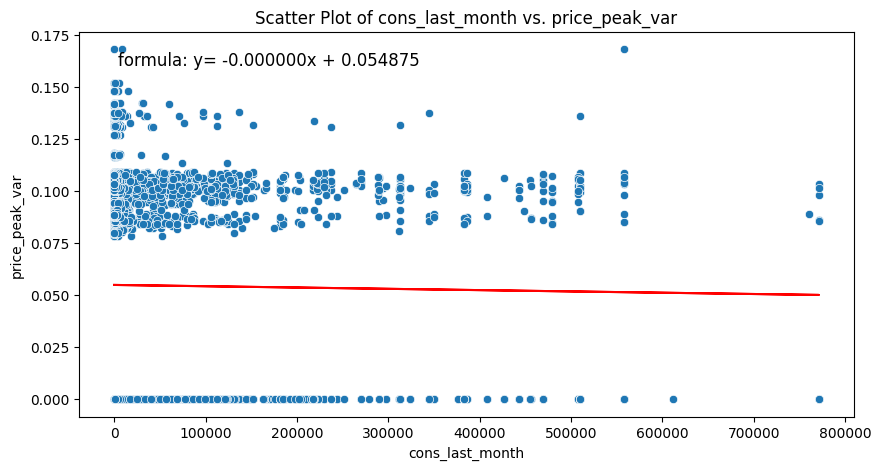

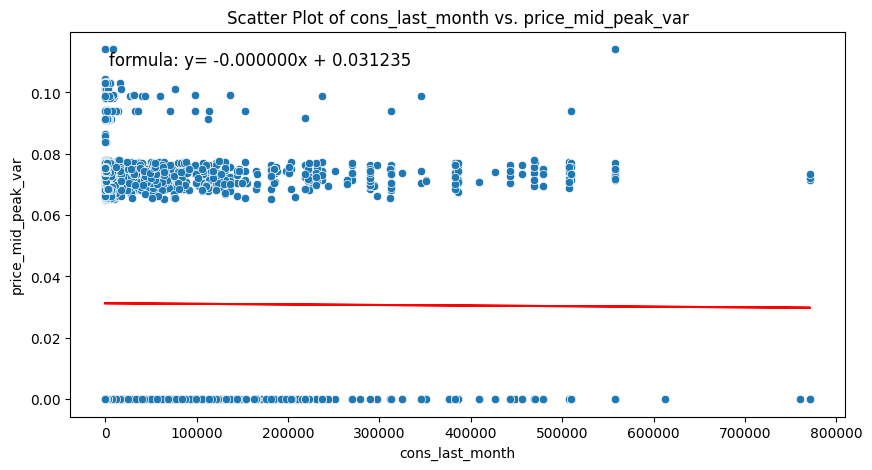

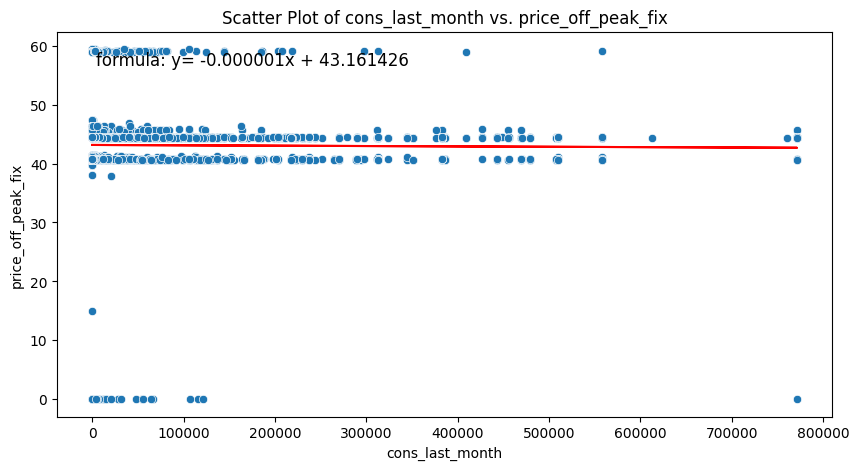

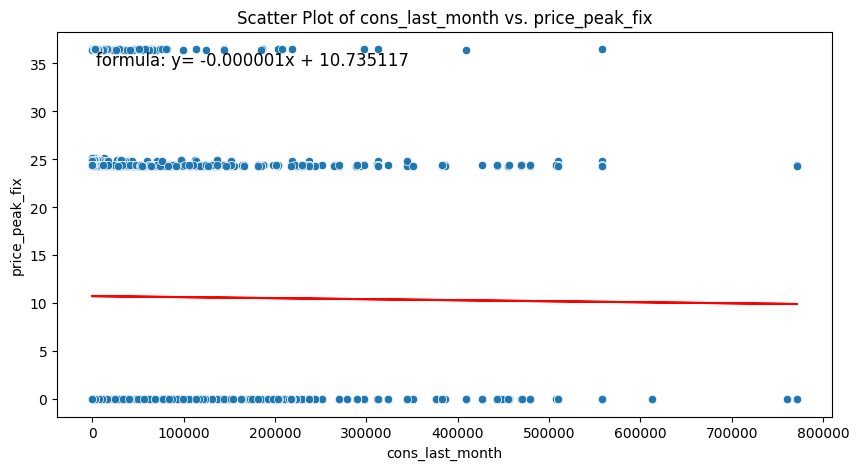

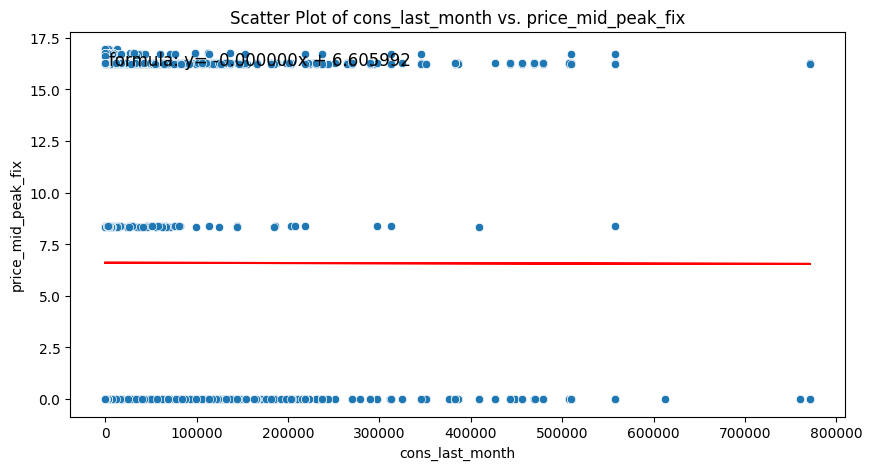

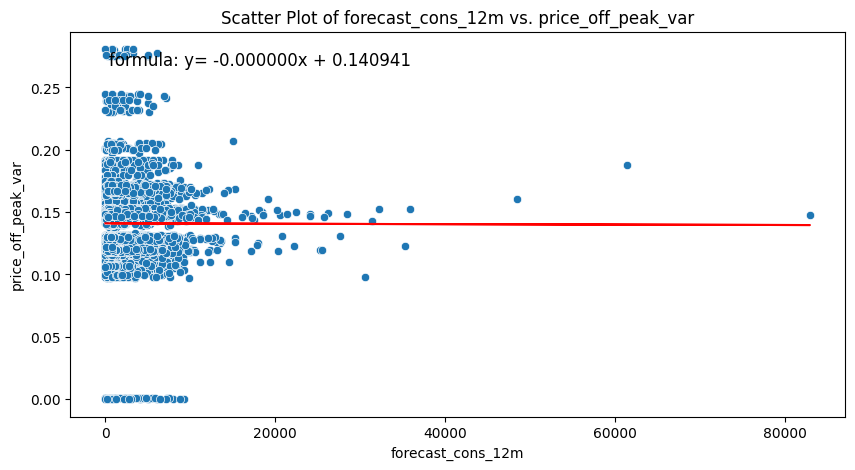

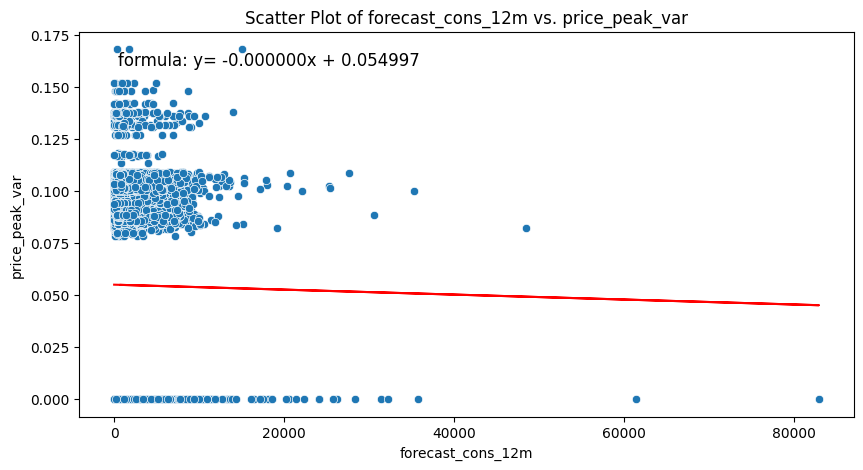

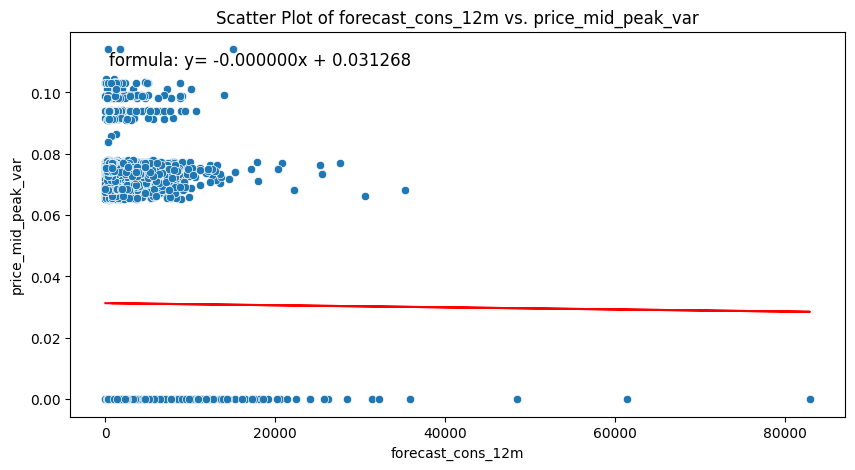

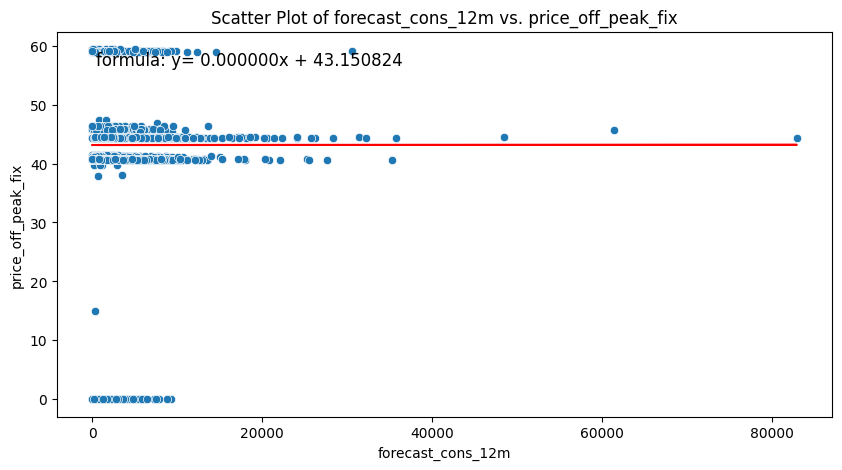

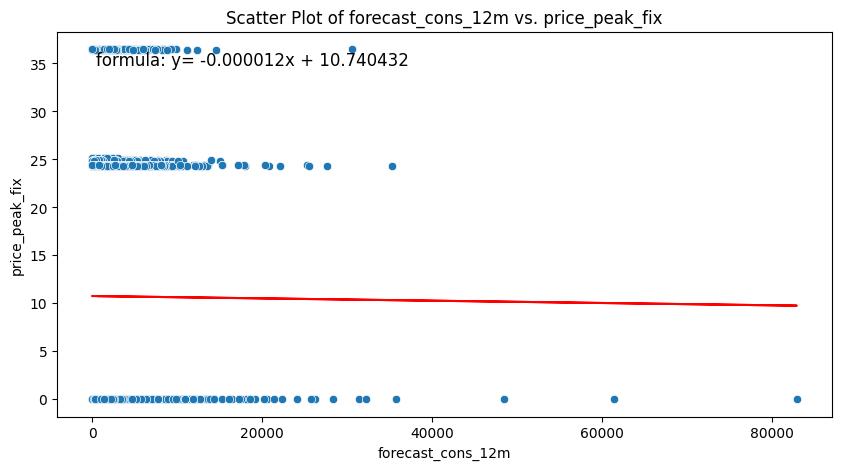

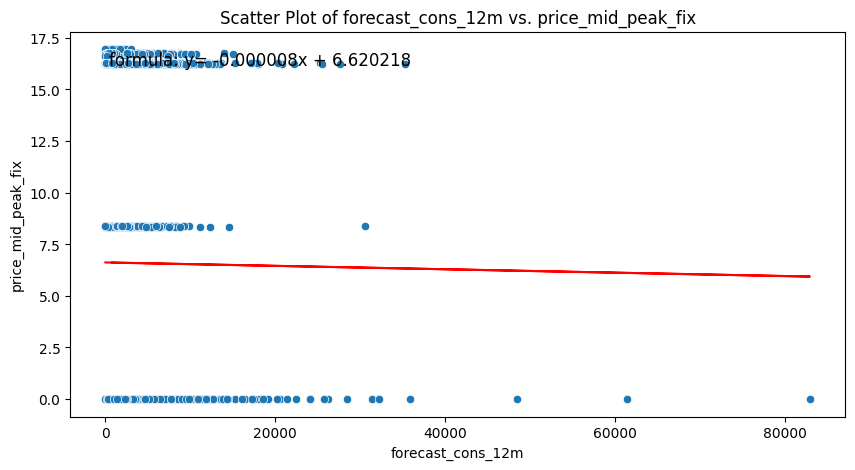

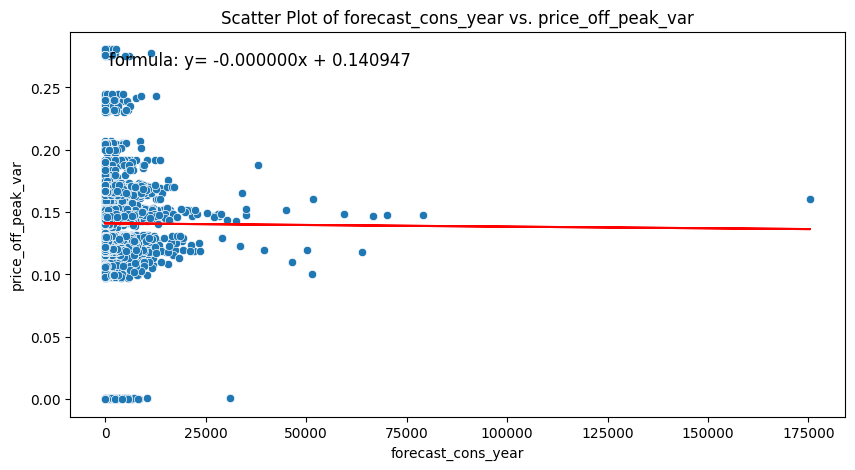

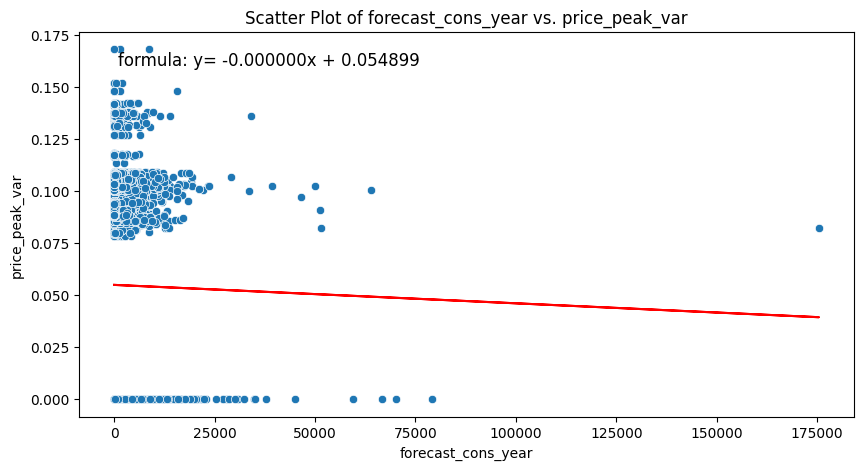

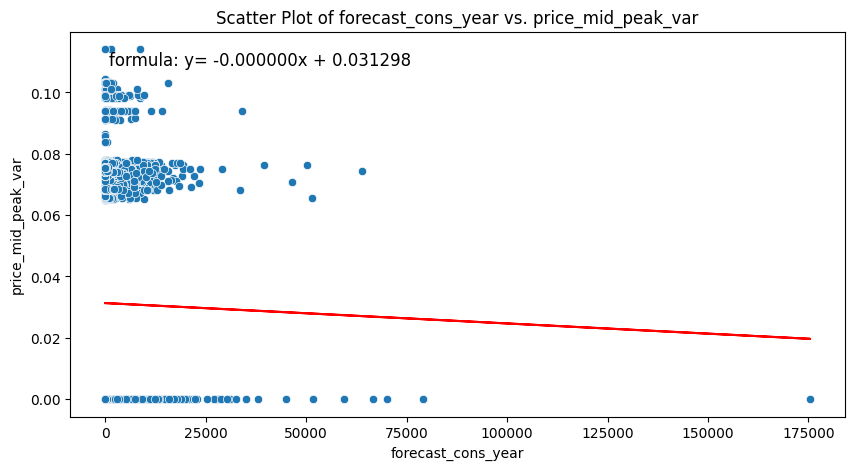

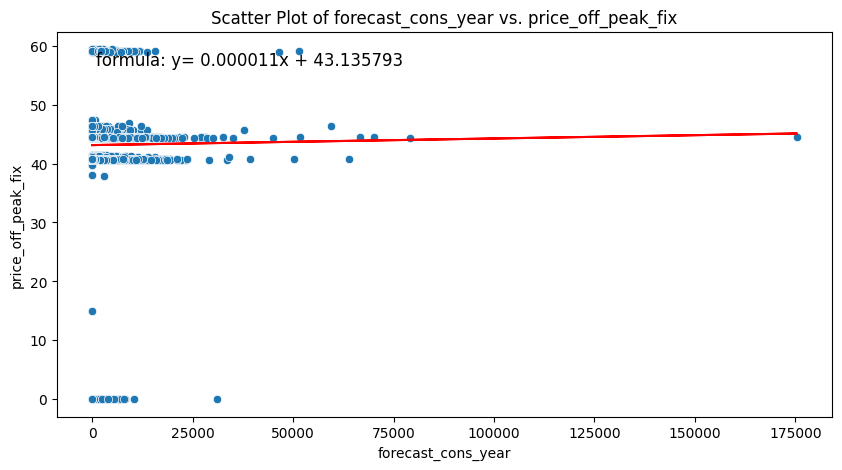

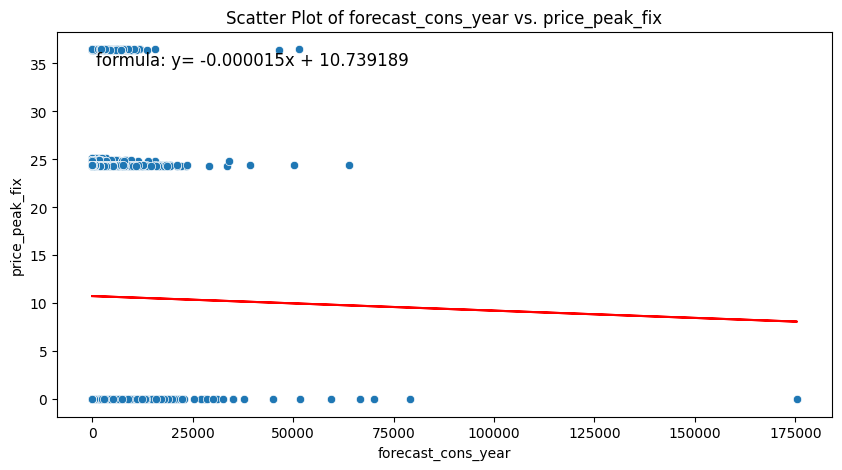

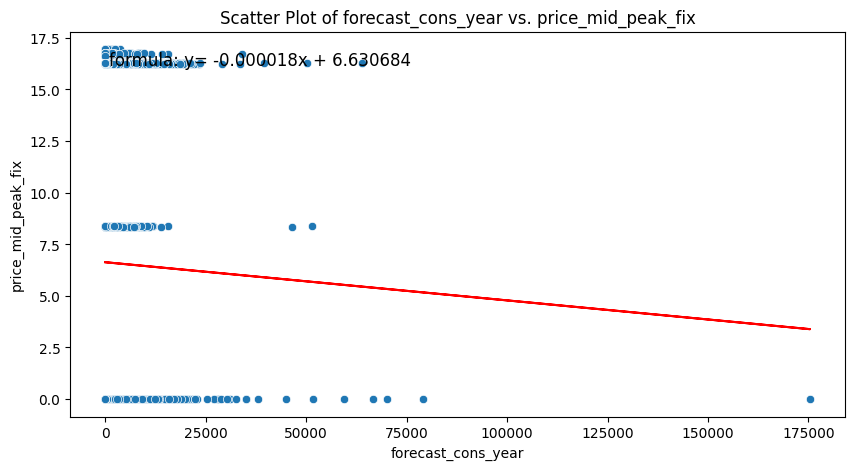

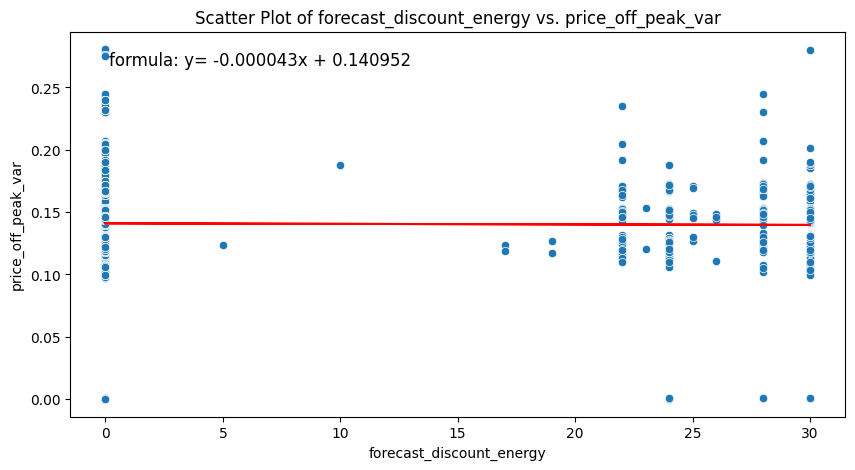

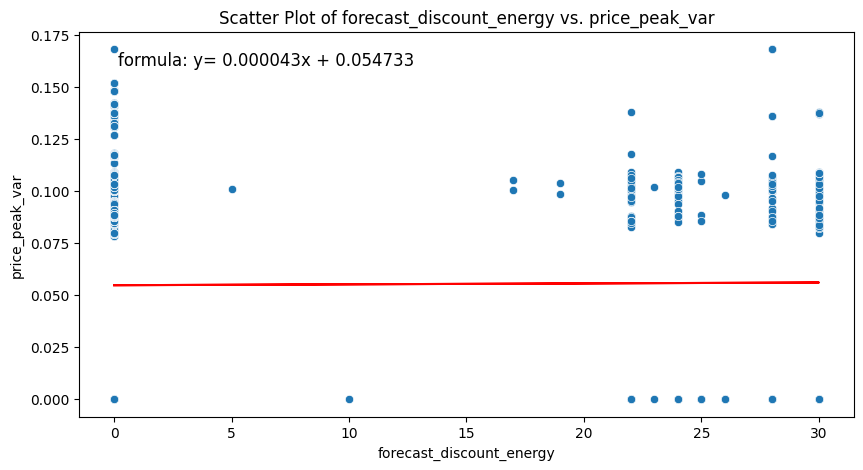

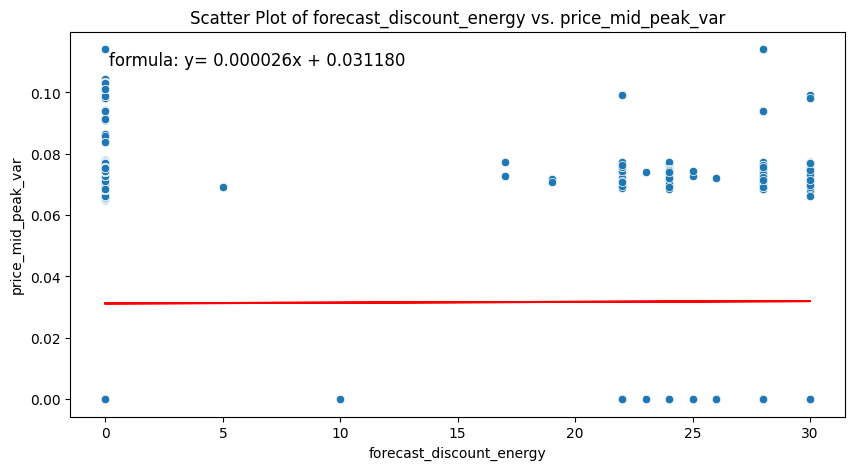

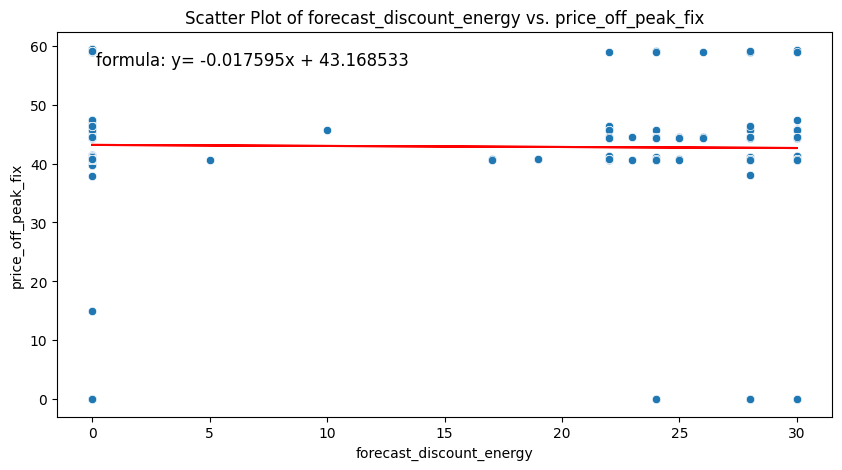

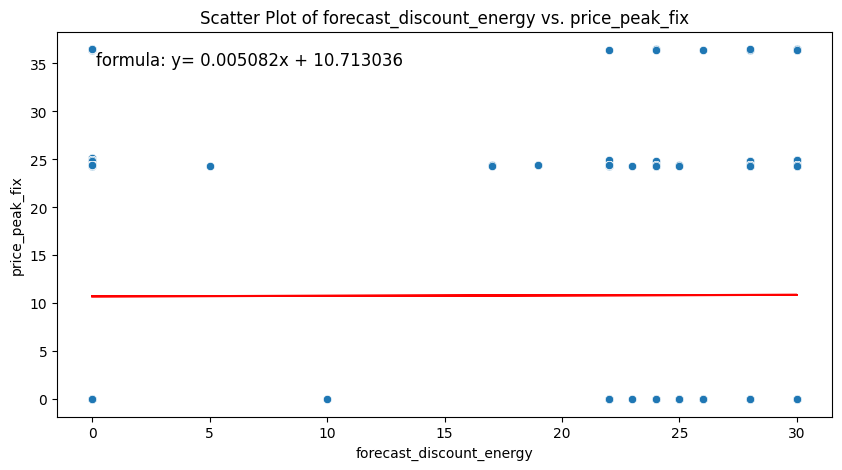

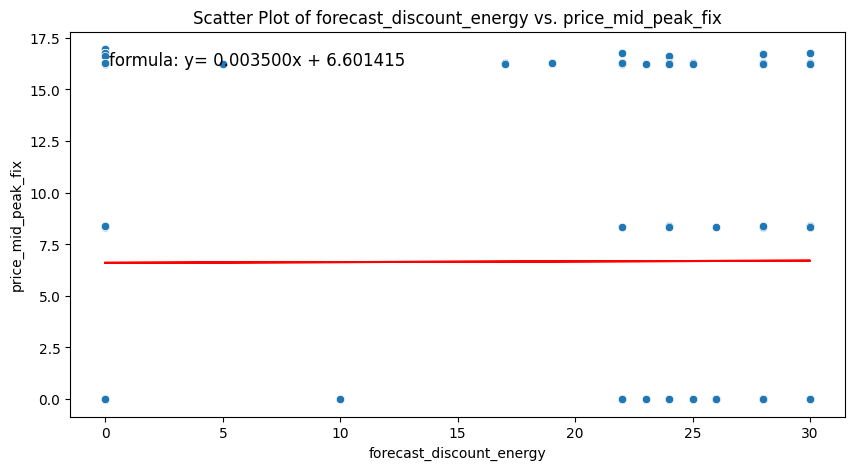

In [ ]:
# price elasticity visualization of demand/consumption vs. price




log_transformed_df= np.log1p(client_df_copy.iloc[:,7:24])
#create a scatter plot to compare each feature match up in merged df
for consumption_col in client_df_copy.iloc[:, 7:13]:
  for price_col in price_df.iloc[:, 2:8]:
    plt.figure(figsize=(10,5))
    sns.scatterplot(data=merged_df, x=consumption_col, y=price_col)
    plt.title(f'Scatter Plot of {consumption_col} vs. {price_col}')

    z= np.polyfit(merged_df[consumption_col], merged_df[price_col], 1)
    m=z[0]
    b=z[1]
    formula_text=f'formula: y= {m:.6f}x + {b:.6f}'
    plt.text(0.05, 0.95, formula_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.plot(merged_df[consumption_col], m*merged_df[consumption_col]+b, color='red')


INSIGHT #___

consumption/demand relative to prices show high elasticity of demand. this supports PowerCo's idea that demand is highly affected by price.
Since elasticity is high for PowerCo, the idea that price sensitivity is a driver of curn is supported.

In [ ]:
#group off-peak prices by companies and month

monthly_price_by_id = price_df.groupby(['id', pd.Grouper(key='price_date', freq='M')])[['price_off_peak_var', 'price_off_peak_fix']]


/tmp/ipython-input-3495059175.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_price_by_id = price_df.groupby(['id', pd.Grouper(key='price_date', freq='M')])[['price_off_peak_var', 'price_off_peak_fix']]


In [ ]:
monthly_price_by_id.head()

# Cleaned Data After EDA

In [ ]:
cleaned_df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0         0         54946                0  2013-06-15  2016-06-15   
1      4660             0                0  2009-08-21  2016-08-30   
2       544             0                0  2010-04-16  2016-04-16   
3      1584             0                0  2010-03-30  2016-03-30   
4      4425             0              526  2010-01-13  2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  forecast_cons_year  \
0      2015-11-01   2015-06-23               0.00                   0   
1      2009-08-21   2015-08-31             189.95                   0   
2      2010-04-16   2015-04-17              47.96                   0   
3      2010-03-30   2015-03-31             240.04                   0   
4      2010-01-13   2015-03-09             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114481                    0.098142   
1                        0.145711                    0.000000   
2                        0.165794                    0.087899   
3                        0.146694                    0.000000   
4                        0.116900                    0.100015   

   forecast_price_pow_off_peak has_gas  imp_cons  margin_gross_pow_ele  \
0                    40.606701       t      0.00                 25.44   
1                    44.311378       f      0.00                 16.38   
2                    44.311378       f      0.00                 28.60   
3                    44.311378       f      0.00                 30.22   
4                    40.606701       f     52.32                 44.91   

   margin_net_pow_ele  nb_prod_act  net_margin  num_years_antig  \
0               25.44            2      678.99                3   
1               16.38            1       18.89                6   
2               28.60            1        6.60                6   
3               30.22            1       25.46                6   
4               44.91            1       47.98                6   

                          origin_up  pow_max  var_year_price_off_peak_var  \
0  lxidpiddsbxsbosboudacockeimpuepw   43.648                     0.000061   
1  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.800                     0.000005   
2  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.856                     0.000006   
3  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.200                     0.000005   
4  kamkkxfxxuwbdslkwifmmcsiusiuosws   19.800                     0.000015   

   var_year_price_peak_var  var_year_price_mid_peak_var  \
0             2.627605e-05                     0.000440   
1             6.089453e-04                     0.000000   
2             2.558511e-07                     0.000000   
3             0.000000e+00                     0.000000   
4             3.552481e-06                     0.000003   

   var_year_price_off_peak_fix  var_year_price_peak_fix  \
0                     1.102785                49.550703   
1                     0.006465                 0.000000   
2                     0.007662                 0.000000   
3                     0.006465                 0.000000   
4                     0.005429               

In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [ ]:
#change dtypes (epecially of date features)
cleaned_df['date_activ']= pd.to_datetime(cleaned_df['date_activ'])
cleaned_df['date_end']= pd.to_datetime(cleaned_df['date_end'])
cleaned_df['date_modif_prod']= pd.to_datetime(cleaned_df['date_modif_prod'])
cleaned_df['date_renewal']= pd.to_datetime(cleaned_df['date_renewal'])